<a href="https://colab.research.google.com/github/erikathea/dpsgd-optimizer/blob/master/MNIST-200.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Differential Privacy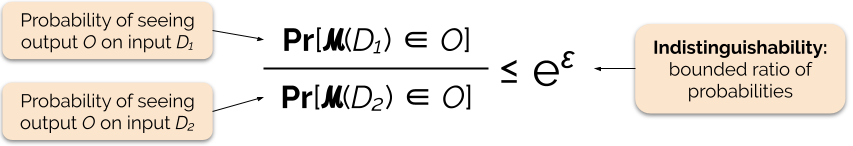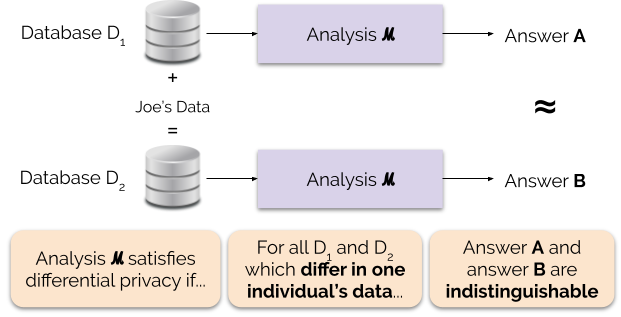

Differential privacy is a mathematical definition of what it means to have privacy. It is not a specific process like de-identification, but a **property** that a process can have. For example, it is possible to prove that a specific algorithm *“satisfies”* differential privacy

Epsilon

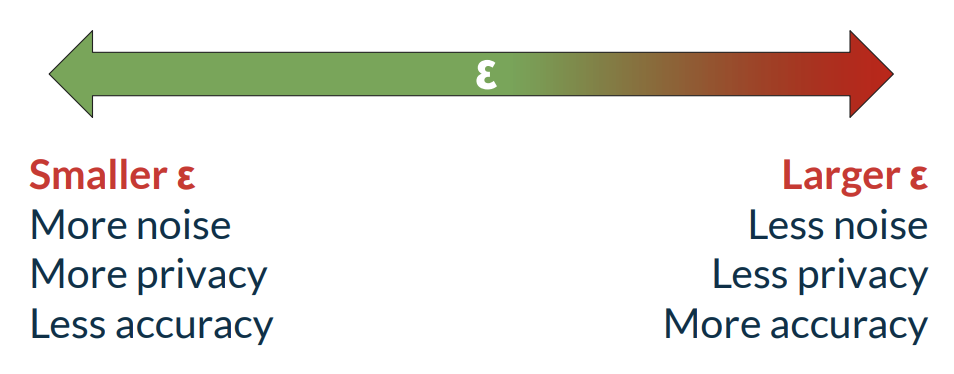

Source: https://www.nist.gov/blogs/cybersecurity-insights/differential-privacy-privacy-preserving-data-analysis-introduction-our

# DP-SGD in Deep Learning

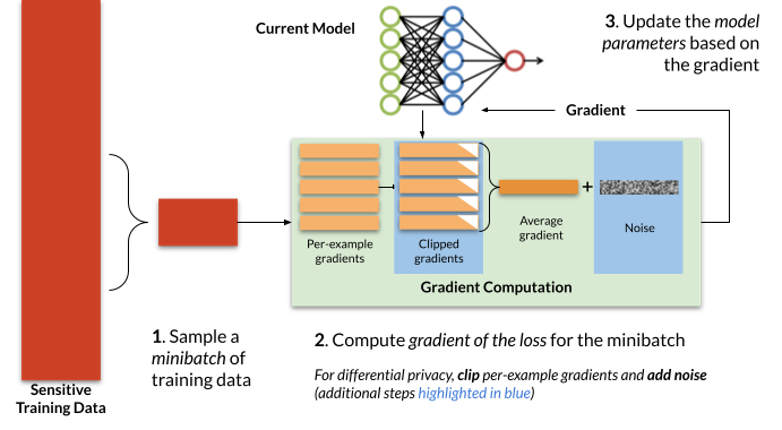

Source: https://www.nist.gov/blogs/cybersecurity-insights/how-deploy-machine-learning-differential-privacy

In [35]:
import tensorflow_datasets as tfds
tfds.image_classification.MNIST

import tensorflow as tf

In [36]:
(mtrain_images, mtrain_labels), (mtest_images, mtest_labels) = tf.keras.datasets.mnist.load_data(path='mnist.npz')

In [37]:
import numpy as np
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(mtrain_images)
test_images = preprocess_images(mtest_images)

In [38]:
import matplotlib.pyplot as plt

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dropout, Flatten, Dense

In [39]:
def shuffle_split_data(X, y):
    arr_rand = np.random.rand(X.shape[0])
    split = arr_rand < np.percentile(arr_rand, 70)
    X_train = X[split]
    y_train = y[split]
    X_test =  X[~split]
    y_test = y[~split]
    return X_train, y_train, X_test, y_test

# Vanilla MNIST CNN

In [ ]:
model = models.Sequential()
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(128, kernel_size = 4, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))


In [ ]:
# Create train/valid set
vtrain_images, vtrain_labels, val_images, val_labels = shuffle_split_data(train_images, mtrain_labels)

In [ ]:
model.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(vtrain_images, vtrain_labels, epochs=200,
                    validation_data=(val_images, val_labels))

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1313/1313 [==============================] - 14s 8ms/step - loss: 0.2964 - accuracy: 0.9081 - val_loss: 0.0809 - val_accuracy: 0.9756
Epoch 2/200
1313/1313 [==============================] - 9s 7ms/step - loss: 0.1130 - accuracy: 0.9644 - val_loss: 0.0575 - val_accuracy: 0.9815
Epoch 3/200
1313/1313 [==============================] - 9s 7ms/step - loss: 0.0830 - accuracy: 0.9741 - val_loss: 0.0521 - val_accuracy: 0.9837
Epoch 4/200
1313/1313 [==============================] - 9s 7ms/step - loss: 0.0680 - accuracy: 0.9785 - val_loss: 0.0445 - val_accuracy: 0.9859
Epoch 5/200
1313/1313 [==============================] - 9s 7ms/step - loss: 0.0598 - accuracy: 0.9813 - val_loss: 0.0458 - val_accuracy: 0.9857
Epoch 6/200
1313/1313 [==============================] - 9s 7ms/step - loss: 0.0549 - accuracy: 0.9824 - val_loss: 0.0424 - val_accuracy: 0.9867
Epoch 7/200
1313/1313 [==============================] - 9s 7ms/step - loss: 0.0503 - accuracy: 0.9839 - val_loss: 0.0389 - val_accuracy: 0.9

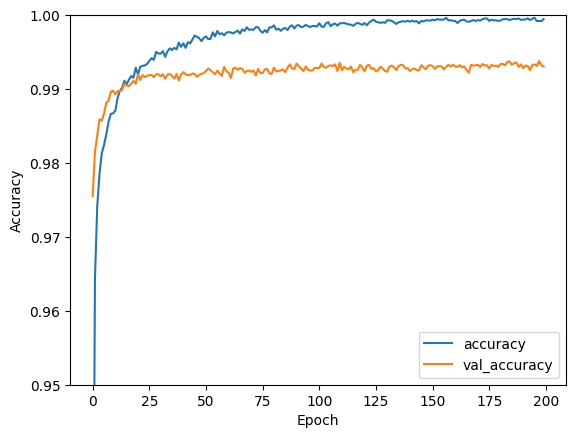

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.95, 1])
plt.legend(loc='lower right')

In [ ]:
test_loss, test_acc = model.evaluate(test_images,  mtest_labels, verbose=2)
print(test_acc)
print(test_loss)

313/313 - 1s - loss: 0.0251 - accuracy: 0.9940 - 667ms/epoch - 2ms/step
0.9940000176429749
0.025099370628595352


# Using DPKerasSGDOptimizer

In [ ]:
!pip install tensorflow_privacy
import tensorflow_privacy

## Training Dataset

In [ ]:
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy_lib

In [ ]:
dptrain_data = np.array(mtrain_images, dtype=np.float32) / 255
dptest_data = np.array(mtest_images, dtype=np.float32) / 255

dptrain_data = dptrain_data.reshape(dptrain_data.shape[0], 28, 28, 1)
dptest_data = dptest_data.reshape(dptest_data.shape[0], 28, 28, 1)

dptrain_labels = np.array(mtrain_labels, dtype=np.int32)
dptest_labels = np.array(mtest_labels, dtype=np.int32)

dptrain_labels = tf.keras.utils.to_categorical(dptrain_labels, num_classes=10)
dptest_labels = tf.keras.utils.to_categorical(dptest_labels, num_classes=10)

In [ ]:
# Create train/valid set
dptrain_images, dptrain_labels, dpval_images, dpval_labels = shuffle_split_data(dptrain_data, dptrain_labels)

In [ ]:
print(f"Training data shape: {dptrain_images.shape}")
print(f"Training labels shape: {dptrain_labels.shape}")

## Model (same as the vanilla version)

In [ ]:
dpmodel = models.Sequential()
dpmodel.add(BatchNormalization())
dpmodel.add(Conv2D(32, kernel_size = 3, activation='relu'))
dpmodel.add(BatchNormalization())
dpmodel.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
dpmodel.add(BatchNormalization())
dpmodel.add(Dropout(0.4))
dpmodel.add(Conv2D(64, kernel_size = 3, activation='relu'))
dpmodel.add(BatchNormalization())
dpmodel.add(Conv2D(64, kernel_size = 3, activation='relu'))
dpmodel.add(BatchNormalization())
dpmodel.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
dpmodel.add(BatchNormalization())
dpmodel.add(Dropout(0.4))
dpmodel.add(Conv2D(128, kernel_size = 4, activation='relu'))
dpmodel.add(BatchNormalization())
dpmodel.add(Flatten())
dpmodel.add(Dropout(0.4))
dpmodel.add(Dense(10, activation='softmax'))

Some starting values you could use for the MNIST dataset:

* l2_norm_clip: This parameter controls the maximum L2 norm of the
gradients, effectively limiting the optimizer’s sensitivity to individual training points. A common starting value could be 1.0.

* noise_multiplier: This parameter controls the amount of noise added to the gradients during optimization. The larger the value, the more noise is added, and the greater the privacy guarantee, but at the cost of model accuracy. You could start with a value like 1.1.

* num_microbatches: This parameter controls the number of microbatches into which each batch of data is split before computing gradients. This can help to improve the accuracy of the gradient computations. A good starting point could be the same as your batch size.

* learning_rate: The learning rate for the SGD optimizer. 1e-3 is a common choice.

## CASE 1: Batch 250, Noise 1.1, l2Norm 1.0, LR 1e-3

In [ ]:
optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=1.0,
    noise_multiplier=1.1,
    num_microbatches=25,
    learning_rate=1e-3)

In [ ]:
dpmodel.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE),
              metrics=['accuracy'])

dphistory = dpmodel.fit(dptrain_images, dptrain_labels, epochs=200, batch_size=250,
                    validation_data=(dpval_images, dpval_labels))

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


168/168 [==============================] - 27s 112ms/step - loss: 3.5224 - accuracy: 0.0995 - val_loss: 2.5929 - val_accuracy: 0.0923
Epoch 2/200
168/168 [==============================] - 18s 109ms/step - loss: 3.4894 - accuracy: 0.1048 - val_loss: 2.7387 - val_accuracy: 0.0766
Epoch 3/200
168/168 [==============================] - 18s 110ms/step - loss: 3.4432 - accuracy: 0.1096 - val_loss: 2.6258 - val_accuracy: 0.1031
Epoch 4/200
168/168 [==============================] - 18s 109ms/step - loss: 3.4027 - accuracy: 0.1131 - val_loss: 2.5606 - val_accuracy: 0.1175
Epoch 5/200
168/168 [==============================] - 18s 109ms/step - loss: 3.3822 - accuracy: 0.1169 - val_loss: 2.5210 - val_accuracy: 0.1293
Epoch 6/200
168/168 [==============================] - 18s 109ms/step - loss: 3.3527 - accuracy: 0.1220 - val_loss: 2.4857 - val_accuracy: 0.1399
Epoch 7/200
168/168 [==============================] - 18s 110ms/step - loss: 3.3127 - accuracy: 0.1229 - val_loss: 2.4473 - val_accurac

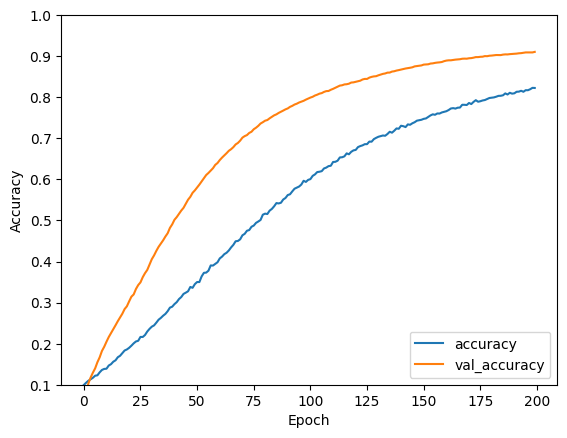

In [ ]:
plt.plot(dphistory.history['accuracy'], label='accuracy')
plt.plot(dphistory.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

In [ ]:
dptest_loss, dptest_acc = dpmodel.evaluate(dptest_data,  dptest_labels, verbose=2)
print(dptest_acc)
print(dptest_loss)

313/313 - 1s - loss: 0.2650 - accuracy: 0.9225 - 1s/epoch - 3ms/step
0.9225000143051147
0.26495859026908875


In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              250, #batch_size=250,
                                              200, #epochs=20,
                                              1.1, #noise_multiplier=1.1,
                                              1e-1) #delta=1e-5)

'DP-SGD performed over 60000 examples with 250 examples per iteration, noise\nmultiplier 1.1 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 0.1 computed with\nRDP accounting:\n    Epsilon with each example occurring once per epoch:       383.311\n    Epsilon assuming Poisson sampling (*):                     16.427\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              250, #batch_size=250,
                                              200, #epochs=20,
                                              1.1, #noise_multiplier=1.1,
                                              1e-2) #delta=1e-5)

'DP-SGD performed over 60000 examples with 250 examples per iteration, noise\nmultiplier 1.1 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 0.01 computed with\nRDP accounting:\n    Epsilon with each example occurring once per epoch:       406.337\n    Epsilon assuming Poisson sampling (*):                     21.284\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              250, #batch_size=250,
                                              200, #epochs=20,
                                              1.1, #noise_multiplier=1.1,
                                              1e-3) #delta=1e-5)

'DP-SGD performed over 60000 examples with 250 examples per iteration, noise\nmultiplier 1.1 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 0.001 computed with\nRDP accounting:\n    Epsilon with each example occurring once per epoch:       428.530\n    Epsilon assuming Poisson sampling (*):                     25.037\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              250, #batch_size=250,
                                              200, #epochs=20,
                                              1.1, #noise_multiplier=1.1,
                                              1e-4) #delta=1e-5)

'DP-SGD performed over 60000 examples with 250 examples per iteration, noise\nmultiplier 1.1 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 0.0001 computed\nwith RDP accounting:\n    Epsilon with each example occurring once per epoch:       440.043\n    Epsilon assuming Poisson sampling (*):                     28.326\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              250, #batch_size=250,
                                              200, #epochs=20,
                                              1.1, #noise_multiplier=1.1,
                                              1e-5) #delta=1e-5)

'DP-SGD performed over 60000 examples with 250 examples per iteration, noise\nmultiplier 1.1 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 1e-05 computed with\nRDP accounting:\n    Epsilon with each example occurring once per epoch:       451.555\n    Epsilon assuming Poisson sampling (*):                     31.210\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              250, #batch_size=250,
                                              200, #epochs=20,
                                              1.1, #noise_multiplier=1.1,
                                              1e-6) #delta=1e-5)

'DP-SGD performed over 60000 examples with 250 examples per iteration, noise\nmultiplier 1.1 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 1e-06 computed with\nRDP accounting:\n    Epsilon with each example occurring once per epoch:       463.068\n    Epsilon assuming Poisson sampling (*):                     33.937\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              250, #batch_size=250,
                                              200, #epochs=20,
                                              1.1, #noise_multiplier=1.1,
                                              1e-7) #delta=1e-5)

'DP-SGD performed over 60000 examples with 250 examples per iteration, noise\nmultiplier 1.1 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 1e-07 computed with\nRDP accounting:\n    Epsilon with each example occurring once per epoch:       474.581\n    Epsilon assuming Poisson sampling (*):                     36.496\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

## CASE 1.1 Batch 250 Noise 4.0, l2Norm 1.0, LR 1e-3

In [ ]:
optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=1.0,
    noise_multiplier=4.0,
    num_microbatches=25,
    learning_rate=1e-3)

dpmodel.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE),
              metrics=['accuracy'])

dphistory = dpmodel.fit(dptrain_images, dptrain_labels, epochs=200, batch_size=250,
                    validation_data=(dpval_images, dpval_labels))

Epoch 1/200
168/168 [==============================] - 23s 111ms/step - loss: 1.7754 - accuracy: 0.4453 - val_loss: 1.0068 - val_accuracy: 0.6771
Epoch 2/200
168/168 [==============================] - 18s 109ms/step - loss: 1.7567 - accuracy: 0.4518 - val_loss: 0.9972 - val_accuracy: 0.6827
Epoch 3/200
168/168 [==============================] - 18s 109ms/step - loss: 1.7422 - accuracy: 0.4521 - val_loss: 0.9773 - val_accuracy: 0.6894
Epoch 4/200
168/168 [==============================] - 18s 109ms/step - loss: 1.7269 - accuracy: 0.4589 - val_loss: 0.9794 - val_accuracy: 0.6899
Epoch 5/200
168/168 [==============================] - 18s 109ms/step - loss: 1.7154 - accuracy: 0.4613 - val_loss: 0.9729 - val_accuracy: 0.6903
Epoch 6/200
168/168 [==============================] - 18s 109ms/step - loss: 1.6999 - accuracy: 0.4615 - val_loss: 0.9733 - val_accuracy: 0.6873
Epoch 7/200
168/168 [==============================] - 18s 110ms/step - loss: 1.6903 - accuracy: 0.4695 - val_loss: 0.9611 -

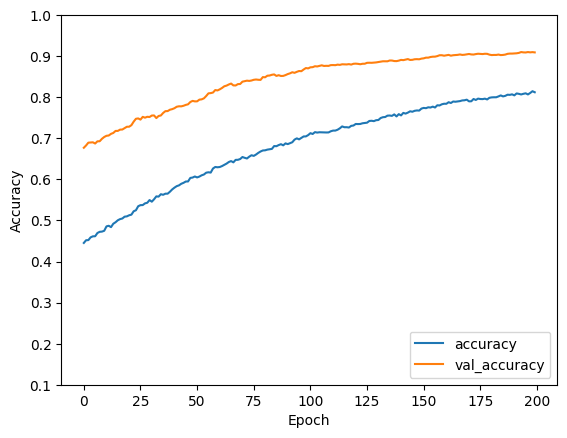

In [ ]:
plt.plot(dphistory.history['accuracy'], label='accuracy')
plt.plot(dphistory.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

In [ ]:
dptest_loss, dptest_acc = dpmodel.evaluate(dptest_data,  dptest_labels, verbose=2)
print(dptest_acc)
print(dptest_loss)

313/313 - 1s - loss: 0.2602 - accuracy: 0.9182 - 948ms/epoch - 3ms/step
0.9182000160217285
0.26016977429389954


In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              250, #batch_size=250,
                                              200, #epochs=20,
                                              4.0, #noise_multiplier=1.1,
                                              1e-1) #delta=1e-1)

'DP-SGD performed over 60000 examples with 250 examples per iteration, noise\nmultiplier 4.0 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 0.1 computed with\nRDP accounting:\n    Epsilon with each example occurring once per epoch:        37.834\n    Epsilon assuming Poisson sampling (*):                      0.491\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              250, #batch_size=250,
                                              200, #epochs=20,
                                              4.0, #noise_multiplier=1.1,
                                              1e-2) #delta=1e-1)

'DP-SGD performed over 60000 examples with 250 examples per iteration, noise\nmultiplier 4.0 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 0.01 computed with\nRDP accounting:\n    Epsilon with each example occurring once per epoch:        44.419\n    Epsilon assuming Poisson sampling (*):                      1.094\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              250, #batch_size=250,
                                              200, #epochs=20,
                                              4.0, #noise_multiplier=1.1,
                                              1e-3) #delta=1e-1)

'DP-SGD performed over 60000 examples with 250 examples per iteration, noise\nmultiplier 4.0 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 0.001 computed with\nRDP accounting:\n    Epsilon with each example occurring once per epoch:        49.406\n    Epsilon assuming Poisson sampling (*):                      1.503\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              250, #batch_size=250,
                                              200, #epochs=20,
                                              4.0, #noise_multiplier=1.1,
                                              1e-4) #delta=1e-1)

'DP-SGD performed over 60000 examples with 250 examples per iteration, noise\nmultiplier 4.0 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 0.0001 computed\nwith RDP accounting:\n    Epsilon with each example occurring once per epoch:        53.586\n    Epsilon assuming Poisson sampling (*):                      1.832\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              250, #batch_size=250,
                                              200, #epochs=20,
                                              4.0, #noise_multiplier=1.1,
                                              1e-5) #delta=1e-1)

'DP-SGD performed over 60000 examples with 250 examples per iteration, noise\nmultiplier 4.0 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 1e-05 computed with\nRDP accounting:\n    Epsilon with each example occurring once per epoch:        57.302\n    Epsilon assuming Poisson sampling (*):                      2.113\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              250, #batch_size=250,
                                              200, #epochs=20,
                                              4.0, #noise_multiplier=1.1,
                                              1e-6) #delta=1e-1)

'DP-SGD performed over 60000 examples with 250 examples per iteration, noise\nmultiplier 4.0 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 1e-06 computed with\nRDP accounting:\n    Epsilon with each example occurring once per epoch:        60.591\n    Epsilon assuming Poisson sampling (*):                      2.363\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              250, #batch_size=250,
                                              200, #epochs=20,
                                              4.0, #noise_multiplier=1.1,
                                              1e-7) #delta=1e-1)

'DP-SGD performed over 60000 examples with 250 examples per iteration, noise\nmultiplier 4.0 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 1e-07 computed with\nRDP accounting:\n    Epsilon with each example occurring once per epoch:        63.602\n    Epsilon assuming Poisson sampling (*):                      2.591\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

## CASE 1.2 Batch 250, Noise 10, l2Norm1.0, LR 0.01

In [ ]:
optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=1.0,
    noise_multiplier=10.0,
    num_microbatches=25,
    learning_rate=1e-3)

dpmodel.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE),
              metrics=['accuracy'])

dphistory = dpmodel.fit(dptrain_images, dptrain_labels, epochs=200, batch_size=250,
                    validation_data=(dpval_images, dpval_labels))

In [ ]:
plt.plot(dphistory.history['accuracy'], label='accuracy')
plt.plot(dphistory.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

In [ ]:
dptest_loss, dptest_acc = dpmodel.evaluate(dptest_data,  dptest_labels, verbose=2)
print(dptest_acc)
print(dptest_loss)

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              250, #batch_size=250,
                                              200, #epochs=20,
                                              10.0, #noise_multiplier=1.1,
                                              1e-1) #delta=1e-1)

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              250, #batch_size=250,
                                              200, #epochs=20,
                                              10.0, #noise_multiplier=1.1,
                                              1e-2) #delta=1e-1)

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              250, #batch_size=250,
                                              200, #epochs=20,
                                              10.0, #noise_multiplier=1.1,
                                              1e-3) #delta=1e-1)

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              250, #batch_size=250,
                                              200, #epochs=20,
                                              10.0, #noise_multiplier=1.1,
                                              1e-4) #delta=1e-1)

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              250, #batch_size=250,
                                              200, #epochs=20,
                                              10.0, #noise_multiplier=1.1,
                                              1e-5) #delta=1e-1)

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              250, #batch_size=250,
                                              200, #epochs=20,
                                              10.0, #noise_multiplier=1.1,
                                              1e-6) #delta=1e-1)

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              250, #batch_size=250,
                                              200, #epochs=20,
                                              10.0, #noise_multiplier=1.1,
                                              1e-7) #delta=1e-1)

## CASE 2: Batch 32, MicroBatch 16, Noise 4.0, l2Norm 1.0, LR 0.01




In [ ]:
optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=1.0,
    noise_multiplier=4.0,
    num_microbatches=16,
    learning_rate=0.01)

dpmodel.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE),
              metrics=['accuracy'])

dphistory = dpmodel.fit(dptrain_images, dptrain_labels, epochs=200, batch_size=32,
                    validation_data=(dpval_images, dpval_labels))

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1313/1313 [==============================] - 33s 22ms/step - loss: 4.7557 - accuracy: 0.1159 - val_loss: 3.2349 - val_accuracy: 0.1583
Epoch 2/200
1313/1313 [==============================] - 28s 21ms/step - loss: 6.2344 - accuracy: 0.1127 - val_loss: 3.7240 - val_accuracy: 0.1262
Epoch 3/200
1313/1313 [==============================] - 28s 21ms/step - loss: 7.1299 - accuracy: 0.1193 - val_loss: 3.8049 - val_accuracy: 0.1424
Epoch 4/200
1313/1313 [==============================] - 28s 21ms/step - loss: 8.3548 - accuracy: 0.1109 - val_loss: 5.0927 - val_accuracy: 0.1058
Epoch 5/200
1313/1313 [==============================] - 28s 21ms/step - loss: 9.1920 - accuracy: 0.1089 - val_loss: 4.7269 - val_accuracy: 0.1609
Epoch 6/200
1313/1313 [==============================] - 28s 21ms/step - loss: 9.9887 - accuracy: 0.1189 - val_loss: 5.0213 - val_accuracy: 0.1623
Epoch 7/200
1313/1313 [==============================] - 28s 21ms/step - loss: 10.4175 - accuracy: 0.1312 - val_loss: 5.4644 - val

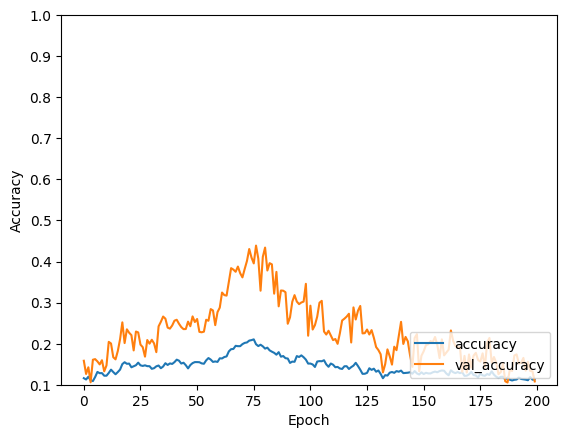

In [ ]:
plt.plot(dphistory.history['accuracy'], label='accuracy')
plt.plot(dphistory.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

In [ ]:
dptest_loss, dptest_acc = dpmodel.evaluate(dptest_data,  dptest_labels, verbose=2)
print(dptest_acc)
print(dptest_loss)

313/313 - 1s - loss: 2.5296 - accuracy: 0.1046 - 692ms/epoch - 2ms/step
0.10459999740123749
2.5296196937561035


In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              32, #batch_size=250,
                                              200, #epochs=20,
                                              4.0, #noise_multiplier=1.1,
                                              1e-1) #delta=1e-1)

'DP-SGD performed over 60000 examples with 32 examples per iteration, noise\nmultiplier 4.0 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 0.1 computed with\nRDP accounting:\n    Epsilon with each example occurring once per epoch:        37.834\n    Epsilon assuming Poisson sampling (*):                      0.010\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              32, #batch_size=250,
                                              200, #epochs=20,
                                              4.0, #noise_multiplier=1.1,
                                              1e-2) #delta=1e-1)

'DP-SGD performed over 60000 examples with 32 examples per iteration, noise\nmultiplier 4.0 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 0.01 computed with\nRDP accounting:\n    Epsilon with each example occurring once per epoch:        44.419\n    Epsilon assuming Poisson sampling (*):                      0.287\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              32, #batch_size=250,
                                              200, #epochs=20,
                                              4.0, #noise_multiplier=1.1,
                                              1e-3) #delta=1e-1)

'DP-SGD performed over 60000 examples with 32 examples per iteration, noise\nmultiplier 4.0 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 0.001 computed with\nRDP accounting:\n    Epsilon with each example occurring once per epoch:        49.406\n    Epsilon assuming Poisson sampling (*):                      0.452\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              32, #batch_size=250,
                                              200, #epochs=20,
                                              4.0, #noise_multiplier=1.1,
                                              1e-4) #delta=1e-1)

'DP-SGD performed over 60000 examples with 32 examples per iteration, noise\nmultiplier 4.0 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 0.0001 computed\nwith RDP accounting:\n    Epsilon with each example occurring once per epoch:        53.586\n    Epsilon assuming Poisson sampling (*):                      0.579\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              32, #batch_size=250,
                                              200, #epochs=20,
                                              4.0, #noise_multiplier=1.1,
                                              1e-5) #delta=1e-1)

'DP-SGD performed over 60000 examples with 32 examples per iteration, noise\nmultiplier 4.0 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 1e-05 computed with\nRDP accounting:\n    Epsilon with each example occurring once per epoch:        57.302\n    Epsilon assuming Poisson sampling (*):                      0.685\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              32, #batch_size=250,
                                              200, #epochs=20,
                                              4.0, #noise_multiplier=1.1,
                                              1e-6) #delta=1e-1)

'DP-SGD performed over 60000 examples with 32 examples per iteration, noise\nmultiplier 4.0 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 1e-06 computed with\nRDP accounting:\n    Epsilon with each example occurring once per epoch:        60.591\n    Epsilon assuming Poisson sampling (*):                      0.778\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              32, #batch_size=250,
                                              200, #epochs=20,
                                              4.0, #noise_multiplier=1.1,
                                              1e-7) #delta=1e-1)

'DP-SGD performed over 60000 examples with 32 examples per iteration, noise\nmultiplier 4.0 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 1e-07 computed with\nRDP accounting:\n    Epsilon with each example occurring once per epoch:        63.602\n    Epsilon assuming Poisson sampling (*):                      0.861\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

## CASE 2.1: Batch size 32, MicroBatch 16, Noise 1.1. l2Norm 1.0, LR 0.01



In [ ]:
optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=1.0,
    noise_multiplier=1.1,
    num_microbatches=16,
    learning_rate=0.01)

dpmodel.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE),
              metrics=['accuracy'])

dphistory = dpmodel.fit(dptrain_images, dptrain_labels, epochs=200, batch_size=32,
                    validation_data=(dpval_images, dpval_labels))

Epoch 1/200
1313/1313 [==============================] - 30s 20ms/step - loss: 3.2433 - accuracy: 0.1443 - val_loss: 2.0175 - val_accuracy: 0.3137
Epoch 2/200
1313/1313 [==============================] - 25s 19ms/step - loss: 3.0208 - accuracy: 0.2005 - val_loss: 1.8605 - val_accuracy: 0.3632
Epoch 3/200
1313/1313 [==============================] - 25s 19ms/step - loss: 2.8570 - accuracy: 0.2444 - val_loss: 1.5901 - val_accuracy: 0.4582
Epoch 4/200
1313/1313 [==============================] - 25s 19ms/step - loss: 2.6365 - accuracy: 0.2935 - val_loss: 1.4324 - val_accuracy: 0.5160
Epoch 5/200
1313/1313 [==============================] - 25s 19ms/step - loss: 2.4603 - accuracy: 0.3449 - val_loss: 1.3067 - val_accuracy: 0.5698
Epoch 6/200
1313/1313 [==============================] - 26s 19ms/step - loss: 2.3031 - accuracy: 0.3905 - val_loss: 1.1234 - val_accuracy: 0.6264
Epoch 7/200
1313/1313 [==============================] - 25s 19ms/step - loss: 2.1395 - accuracy: 0.4323 - val_loss: 1

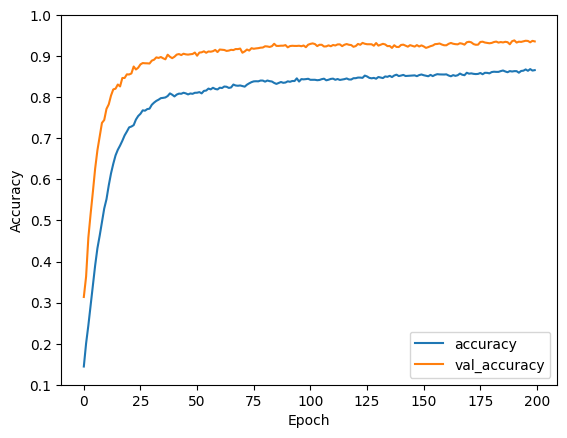

In [ ]:
plt.plot(dphistory.history['accuracy'], label='accuracy')
plt.plot(dphistory.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

In [ ]:
dptest_loss, dptest_acc = dpmodel.evaluate(dptest_data,  dptest_labels, verbose=2)
print(dptest_acc)
print(dptest_loss)

313/313 - 1s - loss: 0.4241 - accuracy: 0.9437 - 672ms/epoch - 2ms/step
0.9437000155448914
0.4241165816783905


In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              32, #batch_size=250,
                                              200, #epochs=20,
                                              1.1, #noise_multiplier=1.1,
                                              1e-1) #delta=1e-1)

'DP-SGD performed over 60000 examples with 32 examples per iteration, noise\nmultiplier 1.1 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 0.1 computed with\nRDP accounting:\n    Epsilon with each example occurring once per epoch:       383.311\n    Epsilon assuming Poisson sampling (*):                      3.718\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              32, #batch_size=250,
                                              200, #epochs=20,
                                              1.1, #noise_multiplier=1.1,
                                              1e-2) #delta=1e-1)

'DP-SGD performed over 60000 examples with 32 examples per iteration, noise\nmultiplier 1.1 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 0.01 computed with\nRDP accounting:\n    Epsilon with each example occurring once per epoch:       406.337\n    Epsilon assuming Poisson sampling (*):                      5.624\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              32, #batch_size=250,
                                              200, #epochs=20,
                                              1.1, #noise_multiplier=1.1,
                                              1e-3) #delta=1e-1)

'DP-SGD performed over 60000 examples with 32 examples per iteration, noise\nmultiplier 1.1 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 0.001 computed with\nRDP accounting:\n    Epsilon with each example occurring once per epoch:       428.530\n    Epsilon assuming Poisson sampling (*):                      7.106\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              32, #batch_size=250,
                                              200, #epochs=20,
                                              1.1, #noise_multiplier=1.1,
                                              1e-4) #delta=1e-1)

'DP-SGD performed over 60000 examples with 32 examples per iteration, noise\nmultiplier 1.1 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 0.0001 computed\nwith RDP accounting:\n    Epsilon with each example occurring once per epoch:       440.043\n    Epsilon assuming Poisson sampling (*):                      8.398\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              32, #batch_size=250,
                                              200, #epochs=20,
                                              1.1, #noise_multiplier=1.1,
                                              1e-5) #delta=1e-1)

'DP-SGD performed over 60000 examples with 32 examples per iteration, noise\nmultiplier 1.1 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 1e-05 computed with\nRDP accounting:\n    Epsilon with each example occurring once per epoch:       451.555\n    Epsilon assuming Poisson sampling (*):                      9.579\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

## CASE 2.2 Batch 32, MicroBatch 16, Noise 10.0, l2Norm 1.0, LR 0.01

In [ ]:
optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=1.0,
    noise_multiplier=10.0,
    num_microbatches=16,
    learning_rate=0.01)

dpmodel.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE),
              metrics=['accuracy'])

dphistory = dpmodel.fit(dptrain_images, dptrain_labels, epochs=200, batch_size=32,
                    validation_data=(dpval_images, dpval_labels))

1313/1313 [==============================] - 30s 19ms/step - loss: 7.8316 - accuracy: 0.1041 - val_loss: 6.3308 - val_accuracy: 0.1049
Epoch 2/200
1313/1313 [==============================] - 25s 19ms/step - loss: 13.8598 - accuracy: 0.1038 - val_loss: 9.0056 - val_accuracy: 0.1021
Epoch 3/200
1313/1313 [==============================] - 25s 19ms/step - loss: 19.6480 - accuracy: 0.1010 - val_loss: 14.1230 - val_accuracy: 0.0922
Epoch 4/200
1313/1313 [==============================] - 25s 19ms/step - loss: 23.4712 - accuracy: 0.1014 - val_loss: 14.3918 - val_accuracy: 0.1001
Epoch 5/200
1313/1313 [==============================] - 25s 19ms/step - loss: 27.2554 - accuracy: 0.1048 - val_loss: 18.3676 - val_accuracy: 0.1075
Epoch 6/200
1313/1313 [==============================] - 25s 19ms/step - loss: 30.0184 - accuracy: 0.1129 - val_loss: 14.9451 - val_accuracy: 0.0913
Epoch 7/200
1313/1313 [==============================] - 25s 19ms/step - loss: 32.4125 - accuracy: 0.1125 - val_loss: 15.

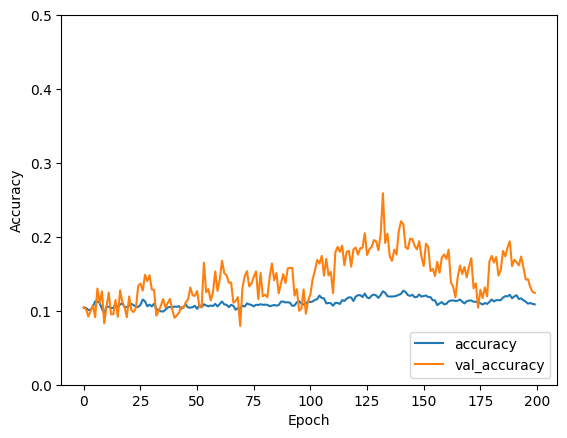

In [ ]:
plt.plot(dphistory.history['accuracy'], label='accuracy')
plt.plot(dphistory.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 0.5])
plt.legend(loc='lower right')

In [ ]:
dptest_loss, dptest_acc = dpmodel.evaluate(dptest_data,  dptest_labels, verbose=2)
print(dptest_acc)
print(dptest_loss)

313/313 - 1s - loss: 52.4007 - accuracy: 0.1264 - 661ms/epoch - 2ms/step
0.12639999389648438
52.40066146850586


In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              32, #batch_size
                                              200, #epochs
                                              10.0, #noise_multiplier
                                              1e-1) #delta

'DP-SGD performed over 60000 examples with 32 examples per iteration, noise\nmultiplier 10.0 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 0.1 computed with\nRDP accounting:\n    Epsilon with each example occurring once per epoch:         8.444\n    Epsilon assuming Poisson sampling (*):                      0.000\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              32, #batch_size
                                              200, #epochs
                                              10.0, #noise_multiplier
                                              1e-2) #delta

'DP-SGD performed over 60000 examples with 32 examples per iteration, noise\nmultiplier 10.0 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 0.01 computed with\nRDP accounting:\n    Epsilon with each example occurring once per epoch:        11.219\n    Epsilon assuming Poisson sampling (*):                      0.071\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              32, #batch_size
                                              200, #epochs
                                              10.0, #noise_multiplier
                                              1e-3) #delta

'DP-SGD performed over 60000 examples with 32 examples per iteration, noise\nmultiplier 10.0 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 0.001 computed with\nRDP accounting:\n    Epsilon with each example occurring once per epoch:        13.293\n    Epsilon assuming Poisson sampling (*):                      0.144\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              32, #batch_size
                                              200, #epochs
                                              10.0, #noise_multiplier
                                              1e-4) #delta

'DP-SGD performed over 60000 examples with 32 examples per iteration, noise\nmultiplier 10.0 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 0.0001 computed\nwith RDP accounting:\n    Epsilon with each example occurring once per epoch:        15.014\n    Epsilon assuming Poisson sampling (*):                      0.197\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              32, #batch_size
                                              200, #epochs
                                              10.0, #noise_multiplier
                                              1e-5) #delta

'DP-SGD performed over 60000 examples with 32 examples per iteration, noise\nmultiplier 10.0 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 1e-05 computed with\nRDP accounting:\n    Epsilon with each example occurring once per epoch:        16.513\n    Epsilon assuming Poisson sampling (*):                      0.240\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              32, #batch_size
                                              200, #epochs
                                              10.0, #noise_multiplier
                                              1e-6) #delta

'DP-SGD performed over 60000 examples with 32 examples per iteration, noise\nmultiplier 10.0 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 1e-06 computed with\nRDP accounting:\n    Epsilon with each example occurring once per epoch:        17.861\n    Epsilon assuming Poisson sampling (*):                      0.277\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              32, #batch_size
                                              200, #epochs
                                              10.0, #noise_multiplier
                                              1e-7) #delta

'DP-SGD performed over 60000 examples with 32 examples per iteration, noise\nmultiplier 10.0 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 1e-07 computed with\nRDP accounting:\n    Epsilon with each example occurring once per epoch:        19.100\n    Epsilon assuming Poisson sampling (*):                      0.314\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

## CASE 2.3 Batch 32, MicroBatch 16, Noise 2.5, l2Norm 1.0, LR 0.01

In [ ]:
optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=1.0,
    noise_multiplier=2.5,
    num_microbatches=16,
    learning_rate=0.01)

dpmodel.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE),
              metrics=['accuracy'])

dphistory = dpmodel.fit(dptrain_images, dptrain_labels, epochs=200, batch_size=32,
                    validation_data=(dpval_images, dpval_labels))

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1313/1313 [==============================] - 30s 19ms/step - loss: 3.8057 - accuracy: 0.1108 - val_loss: 2.6524 - val_accuracy: 0.1658
Epoch 2/200
1313/1313 [==============================] - 25s 19ms/step - loss: 4.4243 - accuracy: 0.1200 - val_loss: 2.8685 - val_accuracy: 0.1491
Epoch 3/200
1313/1313 [==============================] - 25s 19ms/step - loss: 4.8332 - accuracy: 0.1313 - val_loss: 2.9396 - val_accuracy: 0.1438
Epoch 4/200
1313/1313 [==============================] - 25s 19ms/step - loss: 5.2131 - accuracy: 0.1390 - val_loss: 2.8920 - val_accuracy: 0.1931
Epoch 5/200
1313/1313 [==============================] - 25s 19ms/step - loss: 5.7398 - accuracy: 0.1311 - val_loss: 3.1989 - val_accuracy: 0.2041
Epoch 6/200
1313/1313 [==============================] - 25s 19ms/step - loss: 6.0664 - accuracy: 0.1393 - val_loss: 3.2761 - val_accuracy: 0.1704
Epoch 7/200
1313/1313 [==============================] - 25s 19ms/step - loss: 6.2872 - accuracy: 0.1391 - val_loss: 3.3605 - val_

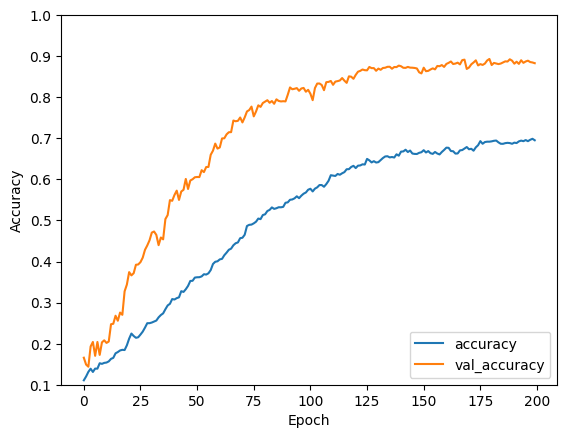

In [ ]:
plt.plot(dphistory.history['accuracy'], label='accuracy')
plt.plot(dphistory.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

In [ ]:
dptest_loss, dptest_acc = dpmodel.evaluate(dptest_data,  dptest_labels, verbose=2)
print(dptest_acc)
print(dptest_loss)

313/313 - 1s - loss: 0.4123 - accuracy: 0.8913 - 676ms/epoch - 2ms/step
0.8913000226020813
0.41225144267082214


In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              32, #batch_size
                                              200, #epochs
                                              2.5, #noise_multiplier
                                              1e-1) #delta

'DP-SGD performed over 60000 examples with 32 examples per iteration, noise\nmultiplier 2.5 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 0.1 computed with\nRDP accounting:\n    Epsilon with each example occurring once per epoch:        85.610\n    Epsilon assuming Poisson sampling (*):                      0.189\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              32, #batch_size
                                              200, #epochs
                                              2.5, #noise_multiplier
                                              1e-2) #delta

'DP-SGD performed over 60000 examples with 32 examples per iteration, noise\nmultiplier 2.5 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 0.01 computed with\nRDP accounting:\n    Epsilon with each example occurring once per epoch:        96.210\n    Epsilon assuming Poisson sampling (*):                      0.611\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              32, #batch_size
                                              200, #epochs
                                              2.5, #noise_multiplier
                                              1e-3) #delta

'DP-SGD performed over 60000 examples with 32 examples per iteration, noise\nmultiplier 2.5 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 0.001 computed with\nRDP accounting:\n    Epsilon with each example occurring once per epoch:       103.885\n    Epsilon assuming Poisson sampling (*):                      0.884\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              32, #batch_size
                                              200, #epochs
                                              2.5, #noise_multiplier
                                              1e-4) #delta

'DP-SGD performed over 60000 examples with 32 examples per iteration, noise\nmultiplier 2.5 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 0.0001 computed\nwith RDP accounting:\n    Epsilon with each example occurring once per epoch:       110.532\n    Epsilon assuming Poisson sampling (*):                      1.100\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              32, #batch_size
                                              200, #epochs
                                              2.5, #noise_multiplier
                                              1e-5) #delta

'DP-SGD performed over 60000 examples with 32 examples per iteration, noise\nmultiplier 2.5 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 1e-05 computed with\nRDP accounting:\n    Epsilon with each example occurring once per epoch:       116.288\n    Epsilon assuming Poisson sampling (*):                      1.283\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              32, #batch_size
                                              200, #epochs
                                              2.5, #noise_multiplier
                                              1e-6) #delta

'DP-SGD performed over 60000 examples with 32 examples per iteration, noise\nmultiplier 2.5 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 1e-06 computed with\nRDP accounting:\n    Epsilon with each example occurring once per epoch:       121.721\n    Epsilon assuming Poisson sampling (*):                      1.443\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              32, #batch_size
                                              200, #epochs
                                              2.5, #noise_multiplier
                                              1e-7) #delta

'DP-SGD performed over 60000 examples with 32 examples per iteration, noise\nmultiplier 2.5 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 1e-07 computed with\nRDP accounting:\n    Epsilon with each example occurring once per epoch:       126.327\n    Epsilon assuming Poisson sampling (*):                      1.590\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

# Testing DPKerasSGDOptimizer using the tutorial from Tensorflow Privacy

In [ ]:

dptrain_data = np.array(mtrain_images, dtype=np.float32) / 255
dptest_data = np.array(mtest_images, dtype=np.float32) / 255

dptrain_data = dptrain_data.reshape(dptrain_data.shape[0], 28, 28, 1)
dptest_data = dptest_data.reshape(dptest_data.shape[0], 28, 28, 1)

dptrain_labels = np.array(mtrain_labels, dtype=np.int32)
dptest_labels = np.array(mtest_labels, dtype=np.int32)

dptrain_labels = tf.keras.utils.to_categorical(dptrain_labels, num_classes=10)
dptest_labels = tf.keras.utils.to_categorical(dptest_labels, num_classes=10)

In [ ]:
dpmodel = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 8,
                           strides=2,
                           padding='same',
                           activation='relu',
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(2, 1),
    tf.keras.layers.Conv2D(32, 4,
                           strides=2,
                           padding='valid',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(2, 1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10)
])

In [ ]:
optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=1.0,
    noise_multiplier=1.1,
    num_microbatches=25,
    learning_rate=0.25)

In [ ]:
dpmodel.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE),
              metrics=['accuracy'])

history = dpmodel.fit(dptrain_data, dptrain_labels, epochs=200, batch_size=250,
                    validation_data=(dptest_data, dptest_labels))

Epoch 1/200
240/240 [==============================] - 7s 12ms/step - loss: 0.9942 - accuracy: 0.6853 - val_loss: 0.7067 - val_accuracy: 0.7943
Epoch 2/200
240/240 [==============================] - 3s 11ms/step - loss: 0.8783 - accuracy: 0.7843 - val_loss: 1.0093 - val_accuracy: 0.7831
Epoch 3/200
240/240 [==============================] - 3s 11ms/step - loss: 1.0079 - accuracy: 0.7866 - val_loss: 0.7924 - val_accuracy: 0.8180
Epoch 4/200
240/240 [==============================] - 3s 11ms/step - loss: 1.0223 - accuracy: 0.7834 - val_loss: 1.0211 - val_accuracy: 0.7766
Epoch 5/200
240/240 [==============================] - 3s 11ms/step - loss: 0.9947 - accuracy: 0.7689 - val_loss: 1.0043 - val_accuracy: 0.7694
Epoch 6/200
240/240 [==============================] - 3s 11ms/step - loss: 0.9833 - accuracy: 0.7611 - val_loss: 1.0077 - val_accuracy: 0.7574
Epoch 7/200
240/240 [==============================] - 3s 11ms/step - loss: 1.0991 - accuracy: 0.7251 - val_loss: 1.1303 - val_accuracy:

313/313 - 1s - loss: 4.8649 - accuracy: 0.1135 - 533ms/epoch - 2ms/step


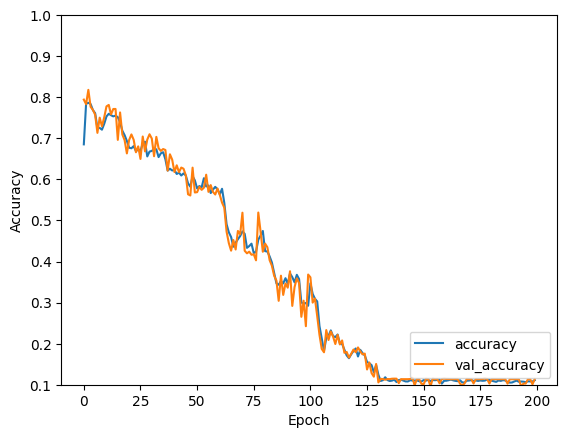

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

test_loss, test_acc = dpmodel.evaluate(dptest_data,  dptest_labels, verbose=2)

In [ ]:
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy_lib

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              250, #batch_size=250,
                                              1.1, #noise_multiplier=1.1,
                                              20, #epochs=20,
                                              1e-5) #delta=1e-5)

'DP-SGD performed over 60000 examples with 250 examples per iteration, noise\nmultiplier 20 for 1.1 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 1e-05 computed with\nRDP accounting:\n    Epsilon with each example occurring once per epoch:         0.546\n    Epsilon assuming Poisson sampling (*):                      0.020\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              32, #batch_size=250,
                                              200, #epochs=20,
                                              4.0, #noise_multiplier=1.1,
                                              1e-6) #delta=1e-1)

'DP-SGD performed over 60000 examples with 32 examples per iteration, noise\nmultiplier 4.0 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 1e-06 computed with\nRDP accounting:\n    Epsilon with each example occurring once per epoch:        60.591\n    Epsilon assuming Poisson sampling (*):                      0.778\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

In [ ]:
compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(dptrain_data.shape[0],
                                              32, #batch_size=250,
                                              200, #epochs=20,
                                              4.0, #noise_multiplier=1.1,
                                              1e-7) #delta=1e-1)

'DP-SGD performed over 60000 examples with 32 examples per iteration, noise\nmultiplier 4.0 for 200 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 1e-07 computed with\nRDP accounting:\n    Epsilon with each example occurring once per epoch:        63.602\n    Epsilon assuming Poisson sampling (*):                      0.861\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed that the actual epsilon\nshould be closer to this value than the conservative assumption of an arbitrary\ndata order.\n'

# Amortized DP-SGD

In [ ]:
from __future__ import division

import abc
import collections
import math
import matplotlib.pyplot as plt
import numpy
from pathlib import Path
import sys
import time

import tensorflow as tf

In [ ]:
def shuffle_split_data(X, y):
    arr_rand = numpy.random.rand(X.shape[0])
    split = arr_rand < numpy.percentile(arr_rand, 70)
    X_train = X[split]
    y_train = y[split]
    X_test =  X[~split]
    y_test = y[~split]
    return X_train, y_train, X_test, y_test

In [ ]:
def random_batch(X, y, batch_size=64):
    idx = numpy.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [ ]:
def print_status_bar(iteration, total, loss, time_taken, metrics=None, spent_eps_delta=None):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                          for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    if spent_eps_delta:
        spent_eps = spent_eps_delta.spent_eps
        spent_delta = spent_eps_delta.spent_delta
        print("\r{}/{} - ".format(iteration, total) + metrics + " - spent eps: " +
               f"{spent_eps:.4f}" + " - spent delta: " + f"{spent_delta:.8f}"
               " - time spent: " + f"{time_taken}" "\n", end=end)
    else:
        print("\r{}/{} - ".format(iteration, total) + metrics + " - spent eps: " +
              " - time spent: " + f"{time_taken}" "\n", end=end)

## dataset

In [30]:
import tensorflow_datasets as tfds
tfds.image_classification.MNIST

(mtrain_images, mtrain_labels), (mtest_images, mtest_labels) = tf.keras.datasets.mnist.load_data(path='mnist.npz')

dpsgdtrain_data = numpy.array(mtrain_images, dtype=numpy.float32) / 255
dpsgdtest_images = numpy.array(mtest_images, dtype=numpy.float32) / 255

dpsgdtrain_data = dpsgdtrain_data.reshape(dpsgdtrain_data.shape[0], 28, 28, 1)
dpsgdtest_images = dpsgdtest_images.reshape(dpsgdtest_images.shape[0], 28, 28, 1)

dpsgdtrain_labels = numpy.array(mtrain_labels, dtype=numpy.int32)
dpsgdtest_labels = numpy.array(mtest_labels, dtype=numpy.int32)

dpsgdtrain_labels = tf.keras.utils.to_categorical(dpsgdtrain_labels, num_classes=10)
dpsgdtest_labels = tf.keras.utils.to_categorical(dpsgdtest_labels, num_classes=10)

# Create train/valid set
dpsgdtrain_images, dpsgdtrain_labels, dpsgdval_images, dpsgdval_labels = shuffle_split_data(dpsgdtrain_data, dpsgdtrain_labels)

## model

In [31]:
def mnist_dp_cnn_model():
    dpmodel = tf.keras.models.Sequential()
    dpmodel.add(tf.keras.layers.BatchNormalization())
    dpmodel.add(tf.keras.layers.Conv2D(32, kernel_size = 3, activation='relu'))
    dpmodel.add(tf.keras.layers.BatchNormalization())
    dpmodel.add(tf.keras.layers.Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    dpmodel.add(tf.keras.layers.BatchNormalization())
    dpmodel.add(tf.keras.layers.Dropout(0.4))
    dpmodel.add(tf.keras.layers.Conv2D(64, kernel_size = 3, activation='relu'))
    dpmodel.add(tf.keras.layers.BatchNormalization())
    dpmodel.add(tf.keras.layers.Conv2D(64, kernel_size = 3, activation='relu'))
    dpmodel.add(tf.keras.layers.BatchNormalization())
    dpmodel.add(tf.keras.layers.Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    dpmodel.add(tf.keras.layers.BatchNormalization())
    dpmodel.add(tf.keras.layers.Dropout(0.4))
    dpmodel.add(tf.keras.layers.Conv2D(128, kernel_size = 4, activation='relu'))
    dpmodel.add(tf.keras.layers.BatchNormalization())
    dpmodel.add(tf.keras.layers.Flatten())
    dpmodel.add(tf.keras.layers.Dropout(0.4))
    dpmodel.add(tf.keras.layers.Dense(10, activation='softmax'))
    return dpmodel

1. **Sequential**: This is the model class in Keras. Models in Keras are defined as a sequence of layers.

2. **BatchNormalization**: This layer normalizes the activations of the previous layer at each batch, i.e., applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. It helps to speed up learning and provides some regularization and noise robustness.

3. **Conv2D**: This is a 2D convolution layer, which creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs. The first parameter `32` is the number of output filters in the convolution, and `kernel_size` specifies the height and width of the 2D convolution window. The `activation` function is `relu`, which stands for Rectified Linear Unit.

4. **Dropout**: This layer randomly sets input units to 0 with a frequency of rate `0.4` at each step during training time, which helps prevent overfitting.

5. **Flatten**: This layer flattens the input. It does not affect the batch size. It's used without parameters.

6. **Dense**: This layer is a regular densely-connected Neural Network (NN) layer. It implements the operation: `output = activation(dot(input, kernel) + bias)`. The `10` in `Dense(10, activation='softmax')` means it uses 10 neurons in the dense layer, and `softmax` activation function is used for multi-class classification problems.

The model you've defined is well-suited for the MNIST dataset. Here's why:

- **Conv2D layers**: These are convolutional layers that will be able to learn spatial hierarchies of features. In the context of MNIST, these could be edges, corners, and other digit-specific features.

- **BatchNormalization layers**: These layers will normalize the activations of the previous layer, which speeds up learning and provides some regularization, helping your model generalize better.

- **Dropout layers**: These layers will randomly set a fraction of input units to 0 during training, which helps prevent overfitting.

- **Flatten layer**: This layer flattens the 2D arrays for fully connected processing in the Dense layer.

- **Dense layer**: The final layer has 10 neurons (one for each digit from 0 to 9) and uses the softmax activation function to output a probability distribution over the 10 digit classes.

## `sanitizer.py`

In [32]:
ClipOption = collections.namedtuple("ClipOption", ["l2norm_bound", "clip"])

def add_gaussian_noise(t, sigma, name=None):
  noisy_t = t + tf.random.normal(tf.shape(t), stddev=sigma)
  return noisy_t

class AmortizedGaussianSanitizer(object):
    def __init__(self, accountant, default_option):
        self._accountant = accountant
        self._default_option = default_option
        self._options = {}
        self.epsilons = []
        self.deltas = []

    def set_option(self, tensor_name, option):
        self._options[tensor_name] = option

    def sanitize(self, x, eps_delta, sigma=None, option=ClipOption(None, None), tensor_name=None, num_examples=None, add_noise=True):
        eps, delta = eps_delta
        if sigma is None:
            with tf.control_dependencies([tf.Assert(tf.greater(eps, 0), ["eps needs to be greater than 0"]),
                                          tf.Assert(tf.greater(delta, 0), ["delta needs to be greater than 0"])]):
                sigma = tf.sqrt(2.0 * tf.math.log(1.25 / delta)) / eps

        l2norm_bound, clip = option
        if l2norm_bound is None:
            l2norm_bound, clip = self._default_option
            if ((tensor_name is not None) and (tensor_name in self._options)):
                l2norm_bound, clip = self._options[tensor_name]
        if clip:
            x = tf.clip_by_norm(x, clip_norm=l2norm_bound)

        if add_noise:
            if num_examples is None:
                num_examples = tf.slice(tf.shape(x), [0], [1])
            privacy_accum_op = self._accountant.accumulate_privacy_spending(eps_delta, sigma, num_examples)
            with tf.control_dependencies([privacy_accum_op]):
                saned_x = add_gaussian_noise(x, sigma * l2norm_bound)
            self.epsilons.append(eps)  # Store epsilon value
            self.deltas.append(delta)  # Store delta value
        else:
            saned_x = tf.reduce_sum(x, 0)
        return saned_x

If `add_noise is True`, then the following operations are performed:

`if num_examples is None: num_examples = tf.slice(tf.shape(x), [0], [1])
`: If the number of examples is not provided, it is set to the first dimension of x, which is typically the batch size in machine learning applications.

`privacy_accum_op = self._accountant.accumulate_privacy_spending(eps_delta, sigma, num_examples)`: This line is calling a method on the accountant object to keep track of the total privacy budget spent so far. The privacy budget is defined by epsilon and delta, and it’s being spent at a rate determined by sigma and the number of examples.

`with tf.control_dependencies([privacy_accum_op]): saned_x = utils.AddGaussianNoise(x, sigma * l2norm_bound)`: This line is adding Gaussian noise to x. The amount of noise is determined by sigma * l2norm_bound. The tf.control_dependencies context ensures that privacy_accum_op is executed before the noise is added.

`self.epsilons.append(eps)` and `self.deltas.append(delta)`: These lines are storing the epsilon and delta values used in this call to sanitize for later analysis.

If `add_noise is False`, then no noise is added and the sum of x along the first axis (typically the batch dimension) is returned.

*This block of code is a key part of differential privacy, which is a technique used to ensure that machine learning models don’t memorize or reveal specific details from the training data. The noise added to the data helps to obscure individual data points while still allowing the model to learn the overall patterns in the data.*

## `accountant.py`



**AmortizedAccountant**: This class keeps track of privacy spending in an amortized way. It assumes all the examples are processed uniformly at random so the spending is amortized among all the examples. It also assumes that Gaussian noise is used, so the accumulation is on `eps^2` and `delta`, using advanced composition.

The key method in this class is `accumulate_privacy_spending`, which accounts for privacy spending when the mechanism operates on a random sample with a sampling probability `q = batch_size / total_examples`.

**GaussianMomentsAccountant**: This class extends the `MomentsAccountant` class and assumes that the noise added is centered Gaussian noise `N(0, sigma^2 I)`. In this case, it can compute the differential moments accurately using a formula.

The key method in this class is `_compute_log_moment`, which computes the high moment of privacy loss.

In [33]:
from __future__ import division

import abc
import collections
import math
import numpy
import sys

import tensorflow as tf

EpsDelta = collections.namedtuple("EpsDelta", ["spent_eps", "spent_delta"])

### AmortizedAccountant

In [34]:
class AmortizedAccountant(object):
  def __init__(self, total_examples):
    assert total_examples > 0
    self._total_examples = total_examples
    self._eps_squared_sum = tf.Variable(tf.zeros([1]), trainable=False,
                                        name="eps_squared_sum")
    self._delta_sum = tf.Variable(tf.zeros([1]), trainable=False,
                                  name="delta_sum")

  def accumulate_privacy_spending(self, eps_delta, unused_sigma,
                                  num_examples):
    eps, delta = eps_delta
    with tf.control_dependencies(
        [tf.Assert(tf.greater(delta, 0),
                   ["delta needs to be greater than 0"])]):
      amortize_ratio = (tf.cast(num_examples, tf.float32) * 1.0 /
                        self._total_examples)
      amortize_eps = tf.reshape(tf.math.log(1.0 + amortize_ratio * (
          tf.exp(eps) - 1.0)), [1])
      amortize_delta = tf.reshape(amortize_ratio * delta, [1])
      return tf.group(*[tf.compat.v1.assign_add(self._eps_squared_sum,
                                      tf.square(amortize_eps)),
                        tf.compat.v1.assign_add(self._delta_sum, amortize_delta)])

  def get_privacy_spent(self, target_eps=None):
    unused_target_eps = target_eps
    eps_squared_sum, delta_sum = ([self._eps_squared_sum, self._delta_sum])
    return [EpsDelta(math.sqrt(eps_squared_sum), float(delta_sum))]

### GaussianMomentsAccountant

In [ ]:
class MomentsAccountant(object):

  __metaclass__ = abc.ABCMeta

  def __init__(self, total_examples, moment_orders=32):
    assert total_examples > 0
    self._total_examples = total_examples
    self._moment_orders = (moment_orders
                           if isinstance(moment_orders, (list, tuple))
                           else range(1, moment_orders + 1))
    self._max_moment_order = max(self._moment_orders)
    assert self._max_moment_order < 100, "The moment order is too large."
    self._log_moments = [tf.Variable(numpy.float64(0.0),
                                     trainable=False,
                                     name=("log_moments-%d" % moment_order))
                         for moment_order in self._moment_orders]

  @abc.abstractmethod
  def _compute_log_moment(self, sigma, q, moment_order):
    pass

  def accumulate_privacy_spending(self, unused_eps_delta,
                                  sigma, num_examples):
    q = tf.cast(num_examples, tf.float64) * 1.0 / self._total_examples

    moments_accum_ops = []
    for i in range(len(self._log_moments)):
      moment = self._compute_log_moment(sigma, q, self._moment_orders[i])
      moments_accum_ops.append(tf.compat.v1.assign_add(self._log_moments[i], moment))
    return tf.group(*moments_accum_ops)

  def _compute_delta(self, log_moments, eps):
    min_delta = 1.0
    for moment_order, log_moment in log_moments:
      if math.isinf(log_moment) or math.isnan(log_moment):
        sys.stderr.write("The %d-th order is inf or Nan\\n" % moment_order)
        continue
      if log_moment < moment_order * eps:
        min_delta = min(min_delta,
                        math.exp(log_moment - moment_order * eps))
    return min_delta

  def _compute_eps(self, log_moments, delta):
    min_eps = float("inf")
    for moment_order, log_moment in log_moments:
      if math.isinf(log_moment) or math.isnan(log_moment):
        sys.stderr.write("The %d-th order is inf or Nan\\n" % moment_order)
        continue
      min_eps = min(min_eps, (log_moment - math.log(delta)) / moment_order)
    return min_eps

  def get_privacy_spent(self, target_eps=None, target_deltas=None):
    assert (target_eps is None) ^ (target_deltas is None)
    eps_deltas = []
    log_moments = self._log_moments
    log_moments_with_order = zip(self._moment_orders, log_moments)
    if target_eps is not None:
      for eps in target_eps:
        eps_deltas.append(
            EpsDelta(eps, self._compute_delta(log_moments_with_order, eps)))
    else:
      assert target_deltas
      for delta in target_deltas:
        eps_deltas.append(
            EpsDelta(self._compute_eps(log_moments_with_order, delta), delta))
    return eps_deltas

In [ ]:
def GenerateBinomialTable(m):
  table = numpy.zeros((m + 1, m + 1), dtype=numpy.float64)
  for i in range(m + 1):
    table[i, 0] = 1
  for i in range(1, m + 1):
    for j in range(1, m + 1):
      v = table[i - 1, j] + table[i - 1, j -1]
      assert not math.isnan(v) and not math.isinf(v)
      table[i, j] = v
  return tf.convert_to_tensor(table)

### MomentsAccountant

In [ ]:
class GaussianMomentsAccountant(MomentsAccountant):

  def __init__(self, total_examples, moment_orders=32):
    super(self.__class__, self).__init__(total_examples, moment_orders)
    self._binomial_table = GenerateBinomialTable(self._max_moment_order)

  def _differential_moments(self, sigma, s, t):
    assert t <= self._max_moment_order, ("The order of %d is out "
                                         "of the upper bound %d."
                                         % (t, self._max_moment_order))
    binomial = tf.slice(self._binomial_table, [0, 0],
                        [t + 1, t + 1])
    ii, jj = numpy.mgrid[:t+1,:t+1]
    signs = 1.0 - 2 * ((ii - jj) % 2)
    exponents = tf.constant([j * (j + 1.0 - 2.0 * s) / (2.0 * sigma * sigma)
                             for j in range(t + 1)], dtype=tf.float64)
    x = tf.multiply(binomial, signs)
    y = tf.multiply(x, tf.exp(exponents))
    z = tf.reduce_sum(y, 1)
    return z

  def _compute_log_moment(self, sigma, q, moment_order):
    assert moment_order <= self._max_moment_order, ("The order of %d is out "
                                                    "of the upper bound %d."
                                                    % (moment_order,
                                                       self._max_moment_order))
    binomial_table = tf.slice(self._binomial_table, [moment_order, 0], [1, moment_order + 1])
    qs = tf.exp(tf.constant([i * 1.0 for i in range(moment_order + 1)],
                            dtype=tf.float64) * tf.cast(
                                tf.math.log(q), dtype=tf.float64))
    moments0 = self._differential_moments(sigma, 0.0, moment_order)
    term0 = tf.reduce_sum(binomial_table * qs * moments0)
    moments1 = self._differential_moments(sigma, 1.0, moment_order)
    term1 = tf.reduce_sum(binomial_table * qs * moments1)
    return tf.squeeze(tf.math.log(tf.cast(q * term0 + (1.0 - q) * term1, tf.float64)))

## training

This is a training loop for a machine learning model that uses differential privacy. Here's a step-by-step explanation:

1. `for epoch in range(1, N_EPOCHS + 1):` This line starts a loop that will go through the training dataset `N_EPOCHS` times. Each pass through the dataset is called an "epoch".

2. `if should_terminate:` This checks if the training should be stopped. If `should_terminate` is `True`, it means the privacy budget has been spent, so it prints the spent epsilon and delta, and breaks the loop.

3. `for step in range(1, n_steps + 1):` This starts a loop for each batch of data in the current epoch. `n_steps` is the number of batches in the dataset.

4. `X_batch, y_batch = random_batch(X_train, y_train)` This line selects a random batch of examples from the training data.

5. The `with tf.GradientTape() as tape:` block is where the forward pass of the model is run and the loss is computed.

6. `gradients = tape.gradient(loss, model.trainable_variables)` This line computes the gradients of the loss with respect to the model's trainable variables.

7. The next block of code sanitizes the gradients to ensure differential privacy. For each gradient, it calls the `sanitize` method, which adds noise to the gradient to ensure privacy. The sanitized gradients are stored in `sanitized_grads`.

8. `spent_eps_delta = accountant.get_privacy_spent(target_eps=target_eps)[0]` This line computes the privacy budget spent so far.

9. `optimizer.apply_gradients(zip(sanitized_grads, model.trainable_variables))` This applies the sanitized gradients to the model's variables, performing one step of the optimization algorithm.

10. The next `if` statement checks if the privacy budget has been exceeded. If so, it sets `should_terminate` to `True`, which will cause the training to stop at the start of the next epoch.

11. The rest of the code in the `for` loop updates the metrics and prints the status bar every 100 steps.

12. After the inner `for` loop (but still inside the `for epoch in range(1, N_EPOCHS + 1):` loop), it prints the status bar for the epoch.

This code is implementing a version of stochastic gradient descent that is differentially private, which is a property that ensures that the model doesn't memorize or reveal specific details about the training data. This is done by adding noise to the gradients before they are applied. The amount of noise is tracked by the `accountant` to ensure that a certain privacy budget is not exceeded.

### pre-training variables

In [40]:
EpsDelta = collections.namedtuple("EpsDelta", ["spent_eps", "spent_delta"])

train_mean_loss = tf.keras.metrics.Mean()
valid_mean_loss = tf.keras.metrics.Mean()
train_acc_scores, valid_acc_scores = list(), list()
train_loss_scores, valid_loss_scores = list(), list()
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
valid_acc_metric = tf.keras.metrics.CategoricalAccuracy()
train_metrics = [tf.keras.metrics.CategoricalAccuracy()]
valid_metrics = [tf.keras.metrics.CategoricalAccuracy()]
test_metrics = [tf.keras.metrics.CategoricalAccuracy()]

In [ ]:
DATASET = 'mnist'
MODEL_TYPE = 'cnn'
USE_PRIVACY = True
PLOT_RESULTS = True

## CASE 3 Batch 32, Noise 1.1, l2Norm 1.0, LR 0.01, Epoch 20

In [ ]:
BATCH_SIZE = 32
LEARNING_RATE = 0.01
L2NORM_BOUND = 1.0
SIGMA = 1.1 #noise
N_EPOCHS = 20

eps = 1.0
delta = 1e-7
max_eps = 64.0
max_delta = 1e-3
target_eps = [64.0]
target_delta = [1e-5] #unused

model = mnist_dp_cnn_model()
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE)
optimizer = tf.optimizers.SGD(LEARNING_RATE)

accountant = AmortizedAccountant(len(dpsgdtrain_images))
sanitizer = AmortizedGaussianSanitizer(accountant, [L2NORM_BOUND / BATCH_SIZE, True])

train_mean_loss = tf.keras.metrics.Mean()
valid_mean_loss = tf.keras.metrics.Mean()
train_acc_scores, valid_acc_scores = list(), list()
train_loss_scores, valid_loss_scores = list(), list()
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
valid_acc_metric = tf.keras.metrics.CategoricalAccuracy()
train_metrics = [tf.keras.metrics.CategoricalAccuracy()]
valid_metrics = [tf.keras.metrics.CategoricalAccuracy()]
test_metrics = [tf.keras.metrics.CategoricalAccuracy()]

In [ ]:
# Run training loop
start_time = time.time()
spent_eps_delta = EpsDelta(0, 0)
should_terminate = False
n_steps = len(dpsgdtrain_images) // BATCH_SIZE
for epoch in range(1, N_EPOCHS + 1):
  if should_terminate:
    spent_eps = spent_eps_delta.spent_eps
    spent_delta = spent_eps_delta.spent_delta
    print(f"Used privacy budget for {spent_eps:.4f}" +
            f" eps, {spent_delta:.8f} delta. Stopping ...")
    break

  print(f"Epoch {epoch}/{N_EPOCHS}")
  for step in range(1, n_steps + 1):
      X_batch, y_batch = random_batch(dpsgdtrain_images, dpsgdtrain_labels)
      with tf.GradientTape() as tape:
          y_pred = model(X_batch, training=True)
          main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
          loss = tf.add_n([main_loss] + model.losses)
          train_acc_metric.update_state(y_batch, y_pred)
      gradients = tape.gradient(loss, model.trainable_variables)

      sanitized_grads = []
      eps_delta = EpsDelta(eps, delta)
      for px_grad in gradients:
          sanitized_grad = sanitizer.sanitize(px_grad, eps_delta, SIGMA)
          sanitized_grads.append(sanitized_grad)
      spent_eps_delta = accountant.get_privacy_spent(target_eps=target_eps)[0]
      optimizer.apply_gradients(zip(sanitized_grads, model.trainable_variables))
      if (spent_eps_delta.spent_eps > max_eps or spent_eps_delta.spent_delta > max_delta):
          should_terminate = True

      train_mean_loss(loss)
      for metric in train_metrics:
          metric(y_batch, y_pred)

      if step % 200 == 0:
          time_taken = time.time() - start_time
          for metric in valid_metrics:
              X_batch, y_batch = random_batch(dpsgdval_images, dpsgdval_labels)
              y_pred = model(X_batch, training=False)
              main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
              loss = tf.add_n([main_loss] + model.losses)
              valid_mean_loss(loss)
              valid_acc_metric.update_state(y_batch, y_pred)
              metric(y_batch, y_pred)

          print_status_bar(step * BATCH_SIZE, len(dpsgdtrain_labels), train_mean_loss, time_taken,
                                train_metrics + valid_metrics, spent_eps_delta,)

  if should_terminate:
      break

  # Update training scores
  train_acc = train_acc_metric.result()
  train_loss = train_mean_loss.result()
  train_acc_scores.append(train_acc)
  train_loss_scores.append(train_loss)
  train_acc_metric.reset_state()
  train_mean_loss.reset_state()

  # Update validation scores
  valid_acc = valid_acc_metric.result()
  valid_loss = valid_mean_loss.result()
  valid_acc_scores.append(valid_acc)
  valid_loss_scores.append(valid_loss)
  valid_acc_metric.reset_state()
  valid_mean_loss.reset_state()

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


6400/42000 - mean: 3.4572 - categorical_accuracy: 0.1073 - categorical_accuracy: 0.1250 - spent eps: 0.3417 - spent delta: 0.00000081 - time spent: 30.384215116500854
12800/42000 - mean: 3.3943 - categorical_accuracy: 0.1133 - categorical_accuracy: 0.1484 - spent eps: 0.4832 - spent delta: 0.00000162 - time spent: 59.836867332458496
19200/42000 - mean: 3.3340 - categorical_accuracy: 0.1191 - categorical_accuracy: 0.1667 - spent eps: 0.5918 - spent delta: 0.00000243 - time spent: 89.47365212440491
25600/42000 - mean: 3.2782 - categorical_accuracy: 0.1248 - categorical_accuracy: 0.1758 - spent eps: 0.6833 - spent delta: 0.00000324 - time spent: 118.9284315109253
32000/42000 - mean: 3.2314 - categorical_accuracy: 0.1315 - categorical_accuracy: 0.1750 - spent eps: 0.7640 - spent delta: 0.00000404 - time spent: 148.29915046691895
38400/42000 - mean: 3.1944 - categorical_accuracy: 0.1360 - categorical_accuracy: 0.2031 - spent eps: 0.8370 - spent delta: 0.00000485 - time spent: 177.7658331394

In [ ]:
# Evaluate model
for metric in test_metrics:
    y_pred = model(dpsgdtest_images, training=False)
    metric(dpsgdtest_labels, y_pred)
metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                      for m in test_metrics or []])
print(f"Training completed, test metrics: {metrics}")

Training completed, test metrics: categorical_accuracy: 0.9066


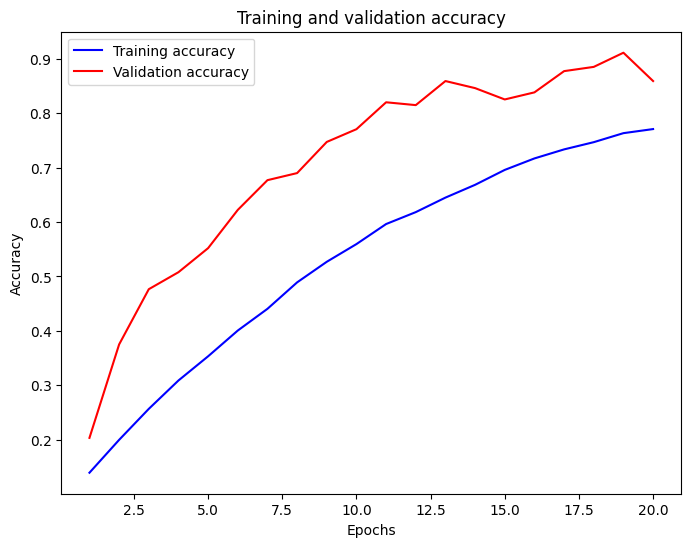

In [ ]:
epochs_range = range(1, N_EPOCHS+1)
plt.figure(figsize=(8,6))
plt.plot(epochs_range, train_acc_scores, color='blue', label='Training accuracy')
plt.plot(epochs_range, valid_acc_scores, color='red', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

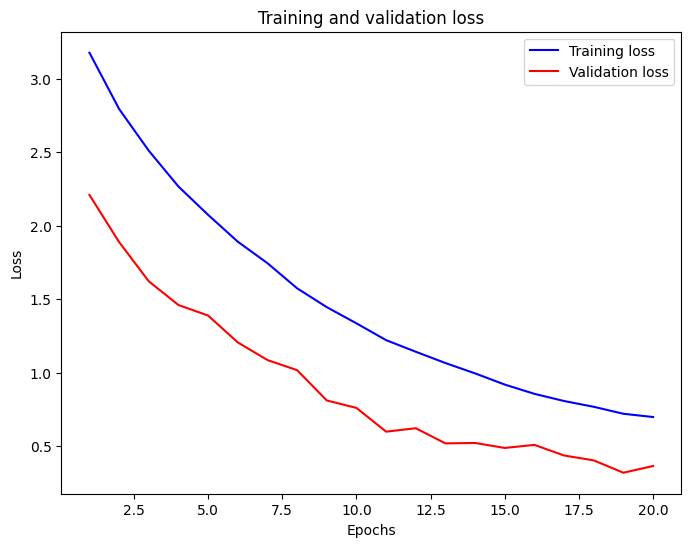

In [ ]:
epochs_range = range(1, N_EPOCHS+1)
plt.figure(figsize=(8,6))
plt.plot(epochs_range, train_loss_scores, color='blue', label='Training loss')
plt.plot(epochs_range, valid_loss_scores, color='red', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## CASE 3.1 Batch 32, Noise 2.5, l2Norm 1.0, LR 0.005

In [51]:
BATCH_SIZE = 32
LEARNING_RATE = 0.005
L2NORM_BOUND = 1.0
SIGMA = 2.5 #noise
N_EPOCHS = 20

eps = 1.0
delta = 1e-7
max_eps = 64.0
max_delta = 1e-3
target_eps = [64.0]
target_delta = [1e-5] #unused

model = mnist_dp_cnn_model()
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE)
optimizer = tf.optimizers.SGD(LEARNING_RATE)

accountant = AmortizedAccountant(len(dpsgdtrain_images))
sanitizer = AmortizedGaussianSanitizer(accountant, [L2NORM_BOUND / BATCH_SIZE, True])

train_mean_loss = tf.keras.metrics.Mean()
valid_mean_loss = tf.keras.metrics.Mean()
train_acc_scores, valid_acc_scores = list(), list()
train_loss_scores, valid_loss_scores = list(), list()
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
valid_acc_metric = tf.keras.metrics.CategoricalAccuracy()
train_metrics = [tf.keras.metrics.CategoricalAccuracy()]
valid_metrics = [tf.keras.metrics.CategoricalAccuracy()]
test_metrics = [tf.keras.metrics.CategoricalAccuracy()]

In [ ]:
# Run training loop
start_time = time.time()
spent_eps_delta = EpsDelta(0, 0)
should_terminate = False
n_steps = len(dpsgdtrain_images) // BATCH_SIZE
for epoch in range(1, N_EPOCHS + 1):
  if should_terminate:
    spent_eps = spent_eps_delta.spent_eps
    spent_delta = spent_eps_delta.spent_delta
    print(f"Used privacy budget for {spent_eps:.4f}" +
            f" eps, {spent_delta:.8f} delta. Stopping ...")
    break

  print(f"Epoch {epoch}/{N_EPOCHS}")
  for step in range(1, n_steps + 1):
      X_batch, y_batch = random_batch(dpsgdtrain_images, dpsgdtrain_labels)
      with tf.GradientTape() as tape:
          y_pred = model(X_batch, training=True)
          main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
          loss = tf.add_n([main_loss] + model.losses)
          train_acc_metric.update_state(y_batch, y_pred)
      gradients = tape.gradient(loss, model.trainable_variables)

      sanitized_grads = []
      eps_delta = EpsDelta(eps, delta)
      for px_grad in gradients:
          sanitized_grad = sanitizer.sanitize(px_grad, eps_delta, SIGMA)
          sanitized_grads.append(sanitized_grad)
      spent_eps_delta = accountant.get_privacy_spent(target_eps=target_eps)[0]
      optimizer.apply_gradients(zip(sanitized_grads, model.trainable_variables))
      if (spent_eps_delta.spent_eps > max_eps or spent_eps_delta.spent_delta > max_delta):
          should_terminate = True

      train_mean_loss(loss)
      for metric in train_metrics:
          metric(y_batch, y_pred)

      #if step % 200 == 0:
      #    time_taken = time.time() - start_time
      #    for metric in valid_metrics:
      #        X_batch, y_batch = random_batch(dpsgdval_images, dpsgdval_labels)
      #        y_pred = model(X_batch, training=False)
      #        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
      #        loss = tf.add_n([main_loss] + model.losses)
      #        valid_mean_loss(loss)
      #        valid_acc_metric.update_state(y_batch, y_pred)
      #        metric(y_batch, y_pred)
      #    print_status_bar(step * BATCH_SIZE, len(dpsgdtrain_labels), train_mean_loss, time_taken, train_metrics + valid_metrics, spent_eps_delta,)

  if should_terminate:
      break

  # Update training scores
  train_acc = train_acc_metric.result()
  train_loss = train_mean_loss.result()
  train_acc_scores.append(train_acc)
  train_loss_scores.append(train_loss)
  train_acc_metric.reset_state()
  train_mean_loss.reset_state()

  # Update validation scores
  valid_acc = valid_acc_metric.result()
  valid_loss = valid_mean_loss.result()
  valid_acc_scores.append(valid_acc)
  valid_loss_scores.append(valid_loss)
  valid_acc_metric.reset_state()
  valid_mean_loss.reset_state()

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20


In [ ]:
# Evaluate model
for metric in test_metrics:
    y_pred = model(dpsgdtest_images, training=False)
    metric(dpsgdtest_labels, y_pred)
metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                      for m in test_metrics or []])
print(f"Training completed, test metrics: {metrics}")

In [ ]:
epochs_range = range(1, N_EPOCHS+1)
plt.plot(epochs_range, train_acc_scores, color='blue', label='Training accuracy')
plt.plot(epochs_range, valid_acc_scores, color='red', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend()


In [ ]:
epochs_range = range(1, N_EPOCHS+1)
plt.plot(epochs_range, train_loss_scores, color='blue', label='Training loss')
plt.plot(epochs_range, valid_loss_scores, color='red', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## CASE 3.2 Batch 32, Noise 4.0, l2Norm 1.0, LR 0.01

In [ ]:
BATCH_SIZE = 32
LEARNING_RATE = 0.01
L2NORM_BOUND = 1.0
SIGMA = 4.0 #noise
N_EPOCHS = 20

eps = 1.0
delta = 1e-7
max_eps = 64.0
max_delta = 1e-3
target_eps = [64.0]
target_delta = [1e-5] #unused

model = mnist_dp_cnn_model()
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE)
optimizer = tf.optimizers.SGD(LEARNING_RATE)

accountant = AmortizedAccountant(len(dpsgdtrain_images))
sanitizer = AmortizedGaussianSanitizer(accountant, [L2NORM_BOUND / BATCH_SIZE, True])

train_mean_loss = tf.keras.metrics.Mean()
valid_mean_loss = tf.keras.metrics.Mean()
train_acc_scores, valid_acc_scores = list(), list()
train_loss_scores, valid_loss_scores = list(), list()
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
valid_acc_metric = tf.keras.metrics.CategoricalAccuracy()
train_metrics = [tf.keras.metrics.CategoricalAccuracy()]
valid_metrics = [tf.keras.metrics.CategoricalAccuracy()]
test_metrics = [tf.keras.metrics.CategoricalAccuracy()]

In [ ]:
# Run training loop
start_time = time.time()
spent_eps_delta = EpsDelta(0, 0)
should_terminate = False
n_steps = len(dpsgdtrain_images) // BATCH_SIZE
for epoch in range(1, N_EPOCHS + 1):
  if should_terminate:
    spent_eps = spent_eps_delta.spent_eps
    spent_delta = spent_eps_delta.spent_delta
    print(f"Used privacy budget for {spent_eps:.4f}" +
            f" eps, {spent_delta:.8f} delta. Stopping ...")
    break

  print(f"Epoch {epoch}/{N_EPOCHS}")
  for step in range(1, n_steps + 1):
      X_batch, y_batch = random_batch(dpsgdtrain_images, dpsgdtrain_labels)
      with tf.GradientTape() as tape:
          y_pred = model(X_batch, training=True)
          main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
          loss = tf.add_n([main_loss] + model.losses)
          train_acc_metric.update_state(y_batch, y_pred)
      gradients = tape.gradient(loss, model.trainable_variables)

      sanitized_grads = []
      eps_delta = EpsDelta(eps, delta)
      for px_grad in gradients:
          sanitized_grad = sanitizer.sanitize(px_grad, eps_delta, SIGMA)
          sanitized_grads.append(sanitized_grad)
      spent_eps_delta = accountant.get_privacy_spent(target_eps=target_eps)[0]
      optimizer.apply_gradients(zip(sanitized_grads, model.trainable_variables))
      if (spent_eps_delta.spent_eps > max_eps or spent_eps_delta.spent_delta > max_delta):
          should_terminate = True

      train_mean_loss(loss)
      for metric in train_metrics:
          metric(y_batch, y_pred)

      if step % 200 == 0:
          time_taken = time.time() - start_time
          for metric in valid_metrics:
              X_batch, y_batch = random_batch(dpsgdval_images, dpsgdval_labels)
              y_pred = model(X_batch, training=False)
              main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
              loss = tf.add_n([main_loss] + model.losses)
              valid_mean_loss(loss)
              valid_acc_metric.update_state(y_batch, y_pred)
              metric(y_batch, y_pred)

          print_status_bar(step * BATCH_SIZE, len(dpsgdtrain_labels), train_mean_loss, time_taken,
                                train_metrics + valid_metrics, spent_eps_delta,)

  if should_terminate:
      break

  # Update training scores
  train_acc = train_acc_metric.result()
  train_loss = train_mean_loss.result()
  train_acc_scores.append(train_acc)
  train_loss_scores.append(train_loss)
  train_acc_metric.reset_state()
  train_mean_loss.reset_state()

  # Update validation scores
  valid_acc = valid_acc_metric.result()
  valid_loss = valid_mean_loss.result()
  valid_acc_scores.append(valid_acc)
  valid_loss_scores.append(valid_loss)
  valid_acc_metric.reset_state()
  valid_mean_loss.reset_state()

Epoch 1/20
6400/42000 - mean: 3.5903 - categorical_accuracy: 0.0988 - categorical_accuracy: 0.0469 - spent eps: 0.3417 - spent delta: 0.00000081 - time spent: 32.63211631774902
12800/42000 - mean: 3.6270 - categorical_accuracy: 0.0984 - categorical_accuracy: 0.0625 - spent eps: 0.4832 - spent delta: 0.00000162 - time spent: 63.22954440116882
19200/42000 - mean: 3.6705 - categorical_accuracy: 0.0980 - categorical_accuracy: 0.0885 - spent eps: 0.5918 - spent delta: 0.00000243 - time spent: 94.84248447418213
25600/42000 - mean: 3.6930 - categorical_accuracy: 0.0985 - categorical_accuracy: 0.0938 - spent eps: 0.6833 - spent delta: 0.00000324 - time spent: 125.69340705871582
32000/42000 - mean: 3.7050 - categorical_accuracy: 0.1004 - categorical_accuracy: 0.0938 - spent eps: 0.7640 - spent delta: 0.00000404 - time spent: 157.167662858963
38400/42000 - mean: 3.7170 - categorical_accuracy: 0.1020 - categorical_accuracy: 0.0938 - spent eps: 0.8370 - spent delta: 0.00000485 - time spent: 188.09

In [ ]:
# Evaluate model
for metric in test_metrics:
    y_pred = model(dpsgdtest_images, training=False)
    metric(dpsgdtest_labels, y_pred)
metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                      for m in test_metrics or []])
print(f"Training completed, test metrics: {metrics}")

Training completed, test metrics: categorical_accuracy: 0.3179


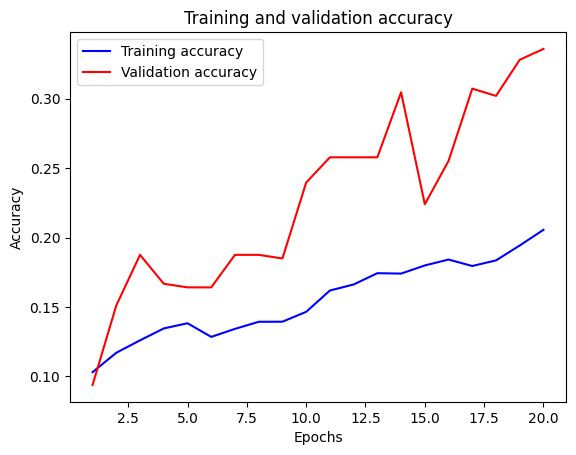

In [ ]:
epochs_range = range(1, N_EPOCHS+1)
plt.plot(epochs_range, train_acc_scores, color='blue', label='Training accuracy')
plt.plot(epochs_range, valid_acc_scores, color='red', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

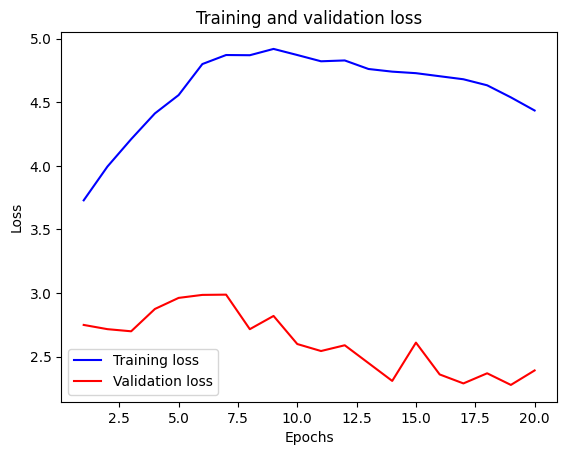

In [ ]:
epochs_range = range(1, N_EPOCHS+1)
plt.plot(epochs_range, train_loss_scores, color='blue', label='Training loss')
plt.plot(epochs_range, valid_loss_scores, color='red', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## CASE 3.3 Batch 32, Noise 10.0, l2Norm 1.0, LR 0.01

In [ ]:
BATCH_SIZE = 32
LEARNING_RATE = 0.01
L2NORM_BOUND = 1.0
SIGMA = 10.0 #noise
N_EPOCHS = 20

eps = 1.0
delta = 1e-7
max_eps = 64.0
max_delta = 1e-3
target_eps = [64.0]
target_delta = [1e-5] #unused

model = mnist_dp_cnn_model()
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE)
optimizer = tf.optimizers.SGD(LEARNING_RATE)

accountant = AmortizedAccountant(len(dpsgdtrain_images))
sanitizer = AmortizedGaussianSanitizer(accountant, [L2NORM_BOUND / BATCH_SIZE, True])

train_mean_loss = tf.keras.metrics.Mean()
valid_mean_loss = tf.keras.metrics.Mean()
train_acc_scores, valid_acc_scores = list(), list()
train_loss_scores, valid_loss_scores = list(), list()
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
valid_acc_metric = tf.keras.metrics.CategoricalAccuracy()
train_metrics = [tf.keras.metrics.CategoricalAccuracy()]
valid_metrics = [tf.keras.metrics.CategoricalAccuracy()]
test_metrics = [tf.keras.metrics.CategoricalAccuracy()]

In [ ]:
# Run training loop
start_time = time.time()
spent_eps_delta = EpsDelta(0, 0)
should_terminate = False
n_steps = len(dpsgdtrain_images) // BATCH_SIZE
for epoch in range(1, N_EPOCHS + 1):
  if should_terminate:
    spent_eps = spent_eps_delta.spent_eps
    spent_delta = spent_eps_delta.spent_delta
    print(f"Used privacy budget for {spent_eps:.4f}" +
            f" eps, {spent_delta:.8f} delta. Stopping ...")
    break

  print(f"Epoch {epoch}/{N_EPOCHS}")
  for step in range(1, n_steps + 1):
      X_batch, y_batch = random_batch(dpsgdtrain_images, dpsgdtrain_labels)
      with tf.GradientTape() as tape:
          y_pred = model(X_batch, training=True)
          main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
          loss = tf.add_n([main_loss] + model.losses)
          train_acc_metric.update_state(y_batch, y_pred)
      gradients = tape.gradient(loss, model.trainable_variables)

      sanitized_grads = []
      eps_delta = EpsDelta(eps, delta)
      for px_grad in gradients:
          sanitized_grad = sanitizer.sanitize(px_grad, eps_delta, SIGMA)
          sanitized_grads.append(sanitized_grad)
      spent_eps_delta = accountant.get_privacy_spent(target_eps=target_eps)[0]
      optimizer.apply_gradients(zip(sanitized_grads, model.trainable_variables))
      if (spent_eps_delta.spent_eps > max_eps or spent_eps_delta.spent_delta > max_delta):
          should_terminate = True

      train_mean_loss(loss)
      for metric in train_metrics:
          metric(y_batch, y_pred)

      if step % 200 == 0:
          time_taken = time.time() - start_time
          for metric in valid_metrics:
              X_batch, y_batch = random_batch(dpsgdval_images, dpsgdval_labels)
              y_pred = model(X_batch, training=False)
              main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
              loss = tf.add_n([main_loss] + model.losses)
              valid_mean_loss(loss)
              valid_acc_metric.update_state(y_batch, y_pred)
              metric(y_batch, y_pred)

          print_status_bar(step * BATCH_SIZE, len(dpsgdtrain_labels), train_mean_loss, time_taken,
                                train_metrics + valid_metrics, spent_eps_delta,)

  if should_terminate:
      break

  # Update training scores
  train_acc = train_acc_metric.result()
  train_loss = train_mean_loss.result()
  train_acc_scores.append(train_acc)
  train_loss_scores.append(train_loss)
  train_acc_metric.reset_state()
  train_mean_loss.reset_state()

  # Update validation scores
  valid_acc = valid_acc_metric.result()
  valid_loss = valid_mean_loss.result()
  valid_acc_scores.append(valid_acc)
  valid_loss_scores.append(valid_loss)
  valid_acc_metric.reset_state()
  valid_mean_loss.reset_state()

Epoch 1/20
6400/42000 - mean: 3.7422 - categorical_accuracy: 0.1039 - categorical_accuracy: 0.1094 - spent eps: 0.3417 - spent delta: 0.00000081 - time spent: 32.066333293914795
12800/42000 - mean: 3.9371 - categorical_accuracy: 0.1046 - categorical_accuracy: 0.1328 - spent eps: 0.4832 - spent delta: 0.00000162 - time spent: 64.02408576011658
19200/42000 - mean: 4.1714 - categorical_accuracy: 0.1010 - categorical_accuracy: 0.1146 - spent eps: 0.5918 - spent delta: 0.00000243 - time spent: 94.50749731063843
25600/42000 - mean: 4.4037 - categorical_accuracy: 0.0997 - categorical_accuracy: 0.1055 - spent eps: 0.6833 - spent delta: 0.00000324 - time spent: 126.35107970237732
32000/42000 - mean: 4.5906 - categorical_accuracy: 0.1010 - categorical_accuracy: 0.1156 - spent eps: 0.7640 - spent delta: 0.00000404 - time spent: 156.9807162284851
38400/42000 - mean: 4.7531 - categorical_accuracy: 0.1029 - categorical_accuracy: 0.1120 - spent eps: 0.8370 - spent delta: 0.00000485 - time spent: 188.

In [ ]:
# Evaluate model
for metric in test_metrics:
    y_pred = model(dpsgdtest_images, training=False)
    metric(dpsgdtest_labels, y_pred)
metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                      for m in test_metrics or []])
print(f"Training completed, test metrics: {metrics}")

Training completed, test metrics: categorical_accuracy: 0.1557


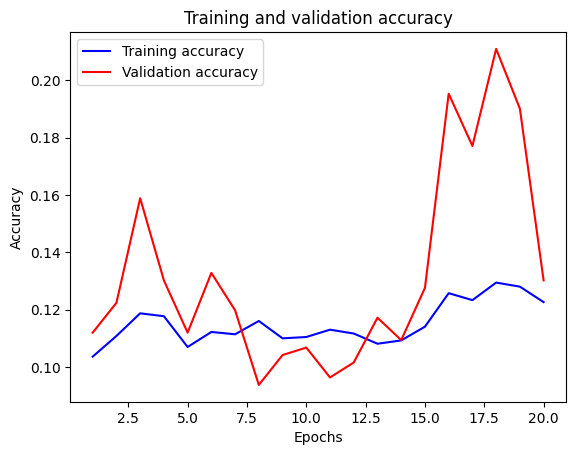

In [ ]:
epochs_range = range(1, N_EPOCHS+1)
plt.plot(epochs_range, train_acc_scores, color='blue', label='Training accuracy')
plt.plot(epochs_range, valid_acc_scores, color='red', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

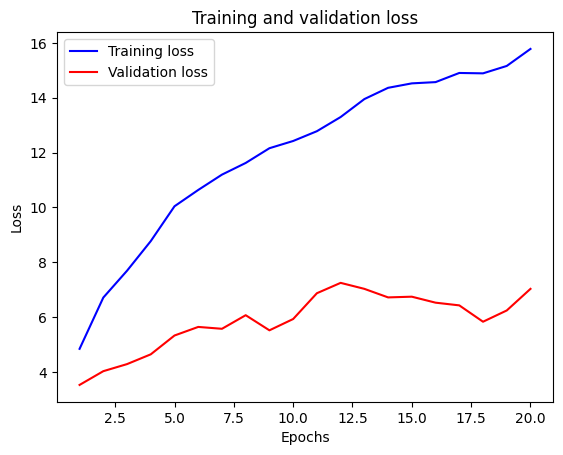

In [ ]:
epochs_range = range(1, N_EPOCHS+1)
plt.plot(epochs_range, train_loss_scores, color='blue', label='Training loss')
plt.plot(epochs_range, valid_loss_scores, color='red', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## CASE 4 Batch 250, Noise 1.1, l2Norm 1.0, LR 0.001

In [ ]:
BATCH_SIZE = 250
LEARNING_RATE = 0.01
L2NORM_BOUND = 1.0
SIGMA = 1.1 #noise
N_EPOCHS = 20

eps = 1.0
delta = 1e-7
max_eps = 64.0
max_delta = 1e-3
target_eps = [64.0]
target_delta = [1e-5] #unused

model = mnist_dp_cnn_model()
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE)
optimizer = tf.optimizers.SGD(LEARNING_RATE)

accountant = AmortizedAccountant(len(dpsgdtrain_images))
sanitizer = AmortizedGaussianSanitizer(accountant, [L2NORM_BOUND / BATCH_SIZE, True])

train_mean_loss = tf.keras.metrics.Mean()
valid_mean_loss = tf.keras.metrics.Mean()
train_acc_scores, valid_acc_scores = list(), list()
train_loss_scores, valid_loss_scores = list(), list()
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
valid_acc_metric = tf.keras.metrics.CategoricalAccuracy()
train_metrics = [tf.keras.metrics.CategoricalAccuracy()]
valid_metrics = [tf.keras.metrics.CategoricalAccuracy()]
test_metrics = [tf.keras.metrics.CategoricalAccuracy()]

In [ ]:
# Run training loop
start_time = time.time()
spent_eps_delta = EpsDelta(0, 0)
should_terminate = False
n_steps = len(dpsgdtrain_images) // BATCH_SIZE
for epoch in range(1, N_EPOCHS + 1):
  if should_terminate:
    spent_eps = spent_eps_delta.spent_eps
    spent_delta = spent_eps_delta.spent_delta
    print(f"Used privacy budget for {spent_eps:.4f}" +
            f" eps, {spent_delta:.8f} delta. Stopping ...")
    break

  print(f"Epoch {epoch}/{N_EPOCHS}")
  for step in range(1, n_steps + 1):
      X_batch, y_batch = random_batch(dpsgdtrain_images, dpsgdtrain_labels)
      with tf.GradientTape() as tape:
          y_pred = model(X_batch, training=True)
          main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
          loss = tf.add_n([main_loss] + model.losses)
          train_acc_metric.update_state(y_batch, y_pred)
      gradients = tape.gradient(loss, model.trainable_variables)

      sanitized_grads = []
      eps_delta = EpsDelta(eps, delta)
      for px_grad in gradients:
          sanitized_grad = sanitizer.sanitize(px_grad, eps_delta, SIGMA)
          sanitized_grads.append(sanitized_grad)
      spent_eps_delta = accountant.get_privacy_spent(target_eps=target_eps)[0]
      optimizer.apply_gradients(zip(sanitized_grads, model.trainable_variables))
      if (spent_eps_delta.spent_eps > max_eps or spent_eps_delta.spent_delta > max_delta):
          should_terminate = True

      train_mean_loss(loss)
      for metric in train_metrics:
          metric(y_batch, y_pred)

      if step % 10 == 0:
          time_taken = time.time() - start_time
          for metric in valid_metrics:
              X_batch, y_batch = random_batch(dpsgdval_images, dpsgdval_labels)
              y_pred = model(X_batch, training=False)
              main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
              loss = tf.add_n([main_loss] + model.losses)
              valid_mean_loss(loss)
              valid_acc_metric.update_state(y_batch, y_pred)
              metric(y_batch, y_pred)

          print_status_bar(step * BATCH_SIZE, len(dpsgdtrain_labels), train_mean_loss, time_taken,
                                train_metrics + valid_metrics, spent_eps_delta,)

  if should_terminate:
      break

  # Update training scores
  train_acc = train_acc_metric.result()
  train_loss = train_mean_loss.result()
  train_acc_scores.append(train_acc)
  train_loss_scores.append(train_loss)
  train_acc_metric.reset_state()
  train_mean_loss.reset_state()

  # Update validation scores
  valid_acc = valid_acc_metric.result()
  valid_loss = valid_mean_loss.result()
  valid_acc_scores.append(valid_acc)
  valid_loss_scores.append(valid_loss)
  valid_acc_metric.reset_state()
  valid_mean_loss.reset_state()

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


2500/42000 - mean: 3.4559 - categorical_accuracy: 0.0875 - categorical_accuracy: 0.0781 - spent eps: 0.0764 - spent delta: 0.00000004 - time spent: 7.789602518081665
5000/42000 - mean: 3.5082 - categorical_accuracy: 0.0852 - categorical_accuracy: 0.1172 - spent eps: 0.1080 - spent delta: 0.00000008 - time spent: 9.43103837966919
7500/42000 - mean: 3.5480 - categorical_accuracy: 0.0849 - categorical_accuracy: 0.0990 - spent eps: 0.1323 - spent delta: 0.00000012 - time spent: 11.279436111450195
10000/42000 - mean: 3.5461 - categorical_accuracy: 0.0871 - categorical_accuracy: 0.0977 - spent eps: 0.1528 - spent delta: 0.00000016 - time spent: 13.0873122215271
12500/42000 - mean: 3.5730 - categorical_accuracy: 0.0897 - categorical_accuracy: 0.1063 - spent eps: 0.1708 - spent delta: 0.00000020 - time spent: 14.67774248123169
15000/42000 - mean: 3.5825 - categorical_accuracy: 0.0870 - categorical_accuracy: 0.1068 - spent eps: 0.1871 - spent delta: 0.00000024 - time spent: 16.26418423652649
17

In [ ]:
# Evaluate model
for metric in test_metrics:
    y_pred = model(dpsgdtest_images, training=False)
    metric(dpsgdtest_labels, y_pred)
metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                      for m in test_metrics or []])
print(f"Training completed, test metrics: {metrics}")

Training completed, test metrics: categorical_accuracy: 0.1618


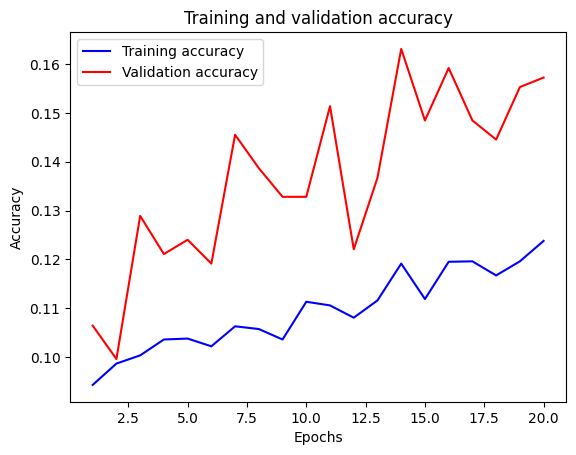

In [ ]:
epochs_range = range(1, N_EPOCHS+1)
plt.plot(epochs_range, train_acc_scores, color='blue', label='Training accuracy')
plt.plot(epochs_range, valid_acc_scores, color='red', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

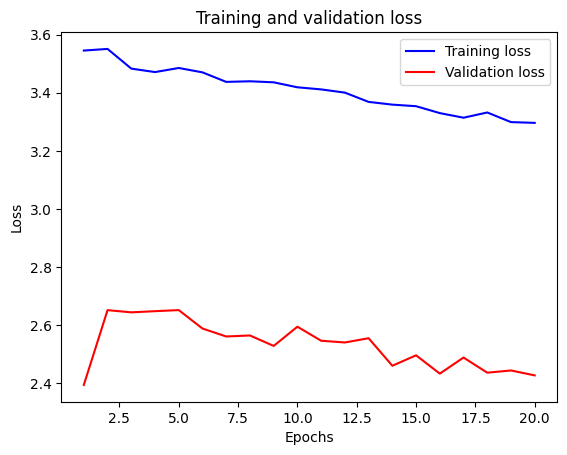

In [ ]:
epochs_range = range(1, N_EPOCHS+1)
plt.plot(epochs_range, train_loss_scores, color='blue', label='Training loss')
plt.plot(epochs_range, valid_loss_scores, color='red', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## CASE 4.1 Batch 250, Noise 2.5, l2Norm 1.0, LR 0.01

In [ ]:
BATCH_SIZE = 250
LEARNING_RATE = 0.01
L2NORM_BOUND = 1.0
SIGMA = 2.5 #noise
N_EPOCHS = 20

eps = 1.0
delta = 1e-7
max_eps = 64.0
max_delta = 1e-3
target_eps = [64.0]
target_delta = [1e-5] #unused

model = mnist_dp_cnn_model()
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE)
optimizer = tf.optimizers.SGD(LEARNING_RATE)

accountant = AmortizedAccountant(len(dpsgdtrain_images))
sanitizer = AmortizedGaussianSanitizer(accountant, [L2NORM_BOUND / BATCH_SIZE, True])

train_mean_loss = tf.keras.metrics.Mean()
valid_mean_loss = tf.keras.metrics.Mean()
train_acc_scores, valid_acc_scores = list(), list()
train_loss_scores, valid_loss_scores = list(), list()
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
valid_acc_metric = tf.keras.metrics.CategoricalAccuracy()
train_metrics = [tf.keras.metrics.CategoricalAccuracy()]
valid_metrics = [tf.keras.metrics.CategoricalAccuracy()]
test_metrics = [tf.keras.metrics.CategoricalAccuracy()]

In [ ]:
# Run training loop
start_time = time.time()
spent_eps_delta = EpsDelta(0, 0)
should_terminate = False
n_steps = len(dpsgdtrain_images) // BATCH_SIZE
for epoch in range(1, N_EPOCHS + 1):
  if should_terminate:
    spent_eps = spent_eps_delta.spent_eps
    spent_delta = spent_eps_delta.spent_delta
    print(f"Used privacy budget for {spent_eps:.4f}" +
            f" eps, {spent_delta:.8f} delta. Stopping ...")
    break

  print(f"Epoch {epoch}/{N_EPOCHS}")
  for step in range(1, n_steps + 1):
      X_batch, y_batch = random_batch(dpsgdtrain_images, dpsgdtrain_labels)
      with tf.GradientTape() as tape:
          y_pred = model(X_batch, training=True)
          main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
          loss = tf.add_n([main_loss] + model.losses)
          train_acc_metric.update_state(y_batch, y_pred)
      gradients = tape.gradient(loss, model.trainable_variables)

      sanitized_grads = []
      eps_delta = EpsDelta(eps, delta)
      for px_grad in gradients:
          sanitized_grad = sanitizer.sanitize(px_grad, eps_delta, SIGMA)
          sanitized_grads.append(sanitized_grad)
      spent_eps_delta = accountant.get_privacy_spent(target_eps=target_eps)[0]
      optimizer.apply_gradients(zip(sanitized_grads, model.trainable_variables))
      if (spent_eps_delta.spent_eps > max_eps or spent_eps_delta.spent_delta > max_delta):
          should_terminate = True

      train_mean_loss(loss)
      for metric in train_metrics:
          metric(y_batch, y_pred)

      if step % 10 == 0:
          time_taken = time.time() - start_time
          for metric in valid_metrics:
              X_batch, y_batch = random_batch(dpsgdval_images, dpsgdval_labels)
              y_pred = model(X_batch, training=False)
              main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
              loss = tf.add_n([main_loss] + model.losses)
              valid_mean_loss(loss)
              valid_acc_metric.update_state(y_batch, y_pred)
              metric(y_batch, y_pred)

          print_status_bar(step * BATCH_SIZE, len(dpsgdtrain_labels), train_mean_loss, time_taken,
                                train_metrics + valid_metrics, spent_eps_delta,)

  if should_terminate:
      break

  # Update training scores
  train_acc = train_acc_metric.result()
  train_loss = train_mean_loss.result()
  train_acc_scores.append(train_acc)
  train_loss_scores.append(train_loss)
  train_acc_metric.reset_state()
  train_mean_loss.reset_state()

  # Update validation scores
  valid_acc = valid_acc_metric.result()
  valid_loss = valid_mean_loss.result()
  valid_acc_scores.append(valid_acc)
  valid_loss_scores.append(valid_loss)
  valid_acc_metric.reset_state()
  valid_mean_loss.reset_state()

Epoch 1/20
2500/42000 - mean: 3.5609 - categorical_accuracy: 0.1141 - categorical_accuracy: 0.1094 - spent eps: 0.0764 - spent delta: 0.00000004 - time spent: 2.8597514629364014
5000/42000 - mean: 3.6298 - categorical_accuracy: 0.1031 - categorical_accuracy: 0.1562 - spent eps: 0.1080 - spent delta: 0.00000008 - time spent: 4.511951923370361
7500/42000 - mean: 3.5997 - categorical_accuracy: 0.1042 - categorical_accuracy: 0.1406 - spent eps: 0.1323 - spent delta: 0.00000012 - time spent: 6.139628171920776
10000/42000 - mean: 3.5786 - categorical_accuracy: 0.0996 - categorical_accuracy: 0.1211 - spent eps: 0.1528 - spent delta: 0.00000016 - time spent: 7.810266494750977
12500/42000 - mean: 3.5831 - categorical_accuracy: 0.1006 - categorical_accuracy: 0.1187 - spent eps: 0.1708 - spent delta: 0.00000020 - time spent: 9.529692649841309
15000/42000 - mean: 3.5794 - categorical_accuracy: 0.1044 - categorical_accuracy: 0.1172 - spent eps: 0.1871 - spent delta: 0.00000024 - time spent: 11.1945

In [ ]:
# Evaluate model
for metric in test_metrics:
    y_pred = model(dpsgdtest_images, training=False)
    metric(dpsgdtest_labels, y_pred)
metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                      for m in test_metrics or []])
print(f"Training completed, test metrics: {metrics}")

Training completed, test metrics: categorical_accuracy: 0.1427


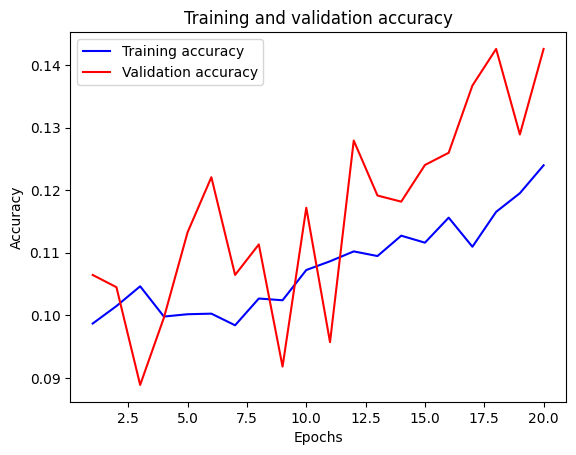

In [ ]:
epochs_range = range(1, N_EPOCHS+1)
plt.plot(epochs_range, train_acc_scores, color='blue', label='Training accuracy')
plt.plot(epochs_range, valid_acc_scores, color='red', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

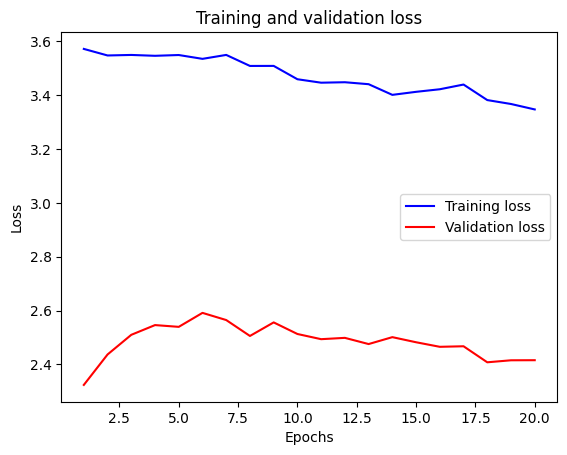

In [ ]:
epochs_range = range(1, N_EPOCHS+1)
plt.plot(epochs_range, train_loss_scores, color='blue', label='Training loss')
plt.plot(epochs_range, valid_loss_scores, color='red', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## CASE 4.2 Batch 250, Noise 4.0, l2Norm 1.0, LR 0.01

In [ ]:
BATCH_SIZE = 250
LEARNING_RATE = 0.01
L2NORM_BOUND = 1.0
SIGMA = 4.0 #noise
N_EPOCHS = 20

eps = 1.0
delta = 1e-7
max_eps = 64.0
max_delta = 1e-3
target_eps = [64.0]
target_delta = [1e-5] #unused

model = mnist_dp_cnn_model()
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE)
optimizer = tf.optimizers.SGD(LEARNING_RATE)

accountant = AmortizedAccountant(len(dpsgdtrain_images))
sanitizer = AmortizedGaussianSanitizer(accountant, [L2NORM_BOUND / BATCH_SIZE, True])

train_mean_loss = tf.keras.metrics.Mean()
valid_mean_loss = tf.keras.metrics.Mean()
train_acc_scores, valid_acc_scores = list(), list()
train_loss_scores, valid_loss_scores = list(), list()
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
valid_acc_metric = tf.keras.metrics.CategoricalAccuracy()
train_metrics = [tf.keras.metrics.CategoricalAccuracy()]
valid_metrics = [tf.keras.metrics.CategoricalAccuracy()]
test_metrics = [tf.keras.metrics.CategoricalAccuracy()]

In [ ]:
# Run training loop
start_time = time.time()
spent_eps_delta = EpsDelta(0, 0)
should_terminate = False
n_steps = len(dpsgdtrain_images) // BATCH_SIZE
for epoch in range(1, N_EPOCHS + 1):
  if should_terminate:
    spent_eps = spent_eps_delta.spent_eps
    spent_delta = spent_eps_delta.spent_delta
    print(f"Used privacy budget for {spent_eps:.4f}" +
            f" eps, {spent_delta:.8f} delta. Stopping ...")
    break

  print(f"Epoch {epoch}/{N_EPOCHS}")
  for step in range(1, n_steps + 1):
      X_batch, y_batch = random_batch(dpsgdtrain_images, dpsgdtrain_labels)
      with tf.GradientTape() as tape:
          y_pred = model(X_batch, training=True)
          main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
          loss = tf.add_n([main_loss] + model.losses)
          train_acc_metric.update_state(y_batch, y_pred)
      gradients = tape.gradient(loss, model.trainable_variables)

      sanitized_grads = []
      eps_delta = EpsDelta(eps, delta)
      for px_grad in gradients:
          sanitized_grad = sanitizer.sanitize(px_grad, eps_delta, SIGMA)
          sanitized_grads.append(sanitized_grad)
      spent_eps_delta = accountant.get_privacy_spent(target_eps=target_eps)[0]
      optimizer.apply_gradients(zip(sanitized_grads, model.trainable_variables))
      if (spent_eps_delta.spent_eps > max_eps or spent_eps_delta.spent_delta > max_delta):
          should_terminate = True

      train_mean_loss(loss)
      for metric in train_metrics:
          metric(y_batch, y_pred)

      if step % 10 == 0:
          time_taken = time.time() - start_time
          for metric in valid_metrics:
              X_batch, y_batch = random_batch(dpsgdval_images, dpsgdval_labels)
              y_pred = model(X_batch, training=False)
              main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
              loss = tf.add_n([main_loss] + model.losses)
              valid_mean_loss(loss)
              valid_acc_metric.update_state(y_batch, y_pred)
              metric(y_batch, y_pred)

          print_status_bar(step * BATCH_SIZE, len(dpsgdtrain_labels), train_mean_loss, time_taken,
                                train_metrics + valid_metrics, spent_eps_delta,)

  if should_terminate:
      break

  # Update training scores
  train_acc = train_acc_metric.result()
  train_loss = train_mean_loss.result()
  train_acc_scores.append(train_acc)
  train_loss_scores.append(train_loss)
  train_acc_metric.reset_state()
  train_mean_loss.reset_state()

  # Update validation scores
  valid_acc = valid_acc_metric.result()
  valid_loss = valid_mean_loss.result()
  valid_acc_scores.append(valid_acc)
  valid_loss_scores.append(valid_loss)
  valid_acc_metric.reset_state()
  valid_mean_loss.reset_state()

Epoch 1/20
2500/42000 - mean: 3.4749 - categorical_accuracy: 0.1156 - categorical_accuracy: 0.0781 - spent eps: 0.0764 - spent delta: 0.00000004 - time spent: 2.874723434448242
5000/42000 - mean: 3.6494 - categorical_accuracy: 0.0969 - categorical_accuracy: 0.1250 - spent eps: 0.1080 - spent delta: 0.00000008 - time spent: 4.487689256668091
7500/42000 - mean: 3.6382 - categorical_accuracy: 0.0927 - categorical_accuracy: 0.1198 - spent eps: 0.1323 - spent delta: 0.00000012 - time spent: 6.1119606494903564
10000/42000 - mean: 3.6176 - categorical_accuracy: 0.0941 - categorical_accuracy: 0.1094 - spent eps: 0.1528 - spent delta: 0.00000016 - time spent: 7.718541383743286
12500/42000 - mean: 3.6211 - categorical_accuracy: 0.0887 - categorical_accuracy: 0.1125 - spent eps: 0.1708 - spent delta: 0.00000020 - time spent: 9.341743469238281
15000/42000 - mean: 3.6436 - categorical_accuracy: 0.0859 - categorical_accuracy: 0.1250 - spent eps: 0.1871 - spent delta: 0.00000024 - time spent: 10.9403

In [ ]:
# Evaluate model
for metric in test_metrics:
    y_pred = model(dpsgdtest_images, training=False)
    metric(dpsgdtest_labels, y_pred)
metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                      for m in test_metrics or []])
print(f"Training completed, test metrics: {metrics}")

Training completed, test metrics: categorical_accuracy: 0.1529


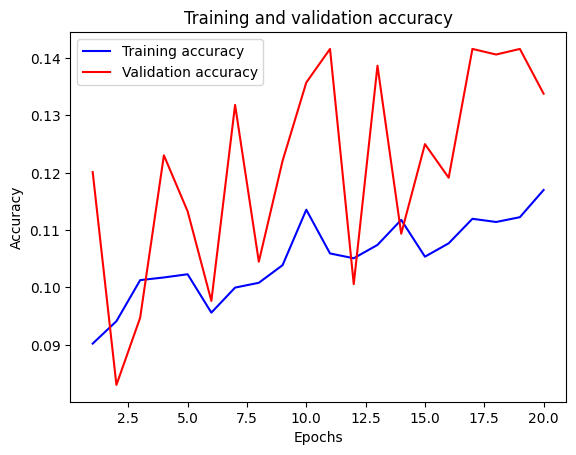

In [ ]:
epochs_range = range(1, N_EPOCHS+1)
plt.plot(epochs_range, train_acc_scores, color='blue', label='Training accuracy')
plt.plot(epochs_range, valid_acc_scores, color='red', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

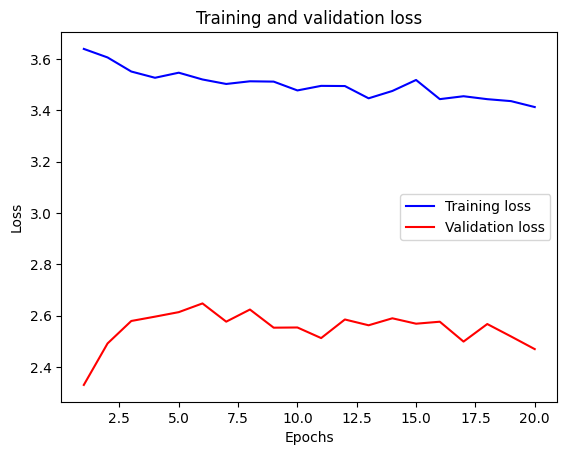

In [ ]:
epochs_range = range(1, N_EPOCHS+1)
plt.plot(epochs_range, train_loss_scores, color='blue', label='Training loss')
plt.plot(epochs_range, valid_loss_scores, color='red', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## CASE 4.3 Batch 250, Noise 10.0 l2Norm 1.0, LR 0.01

In [ ]:
BATCH_SIZE = 250
LEARNING_RATE = 0.01
L2NORM_BOUND = 1.0
SIGMA = 4.0 #noise
N_EPOCHS = 20

eps = 1.0
delta = 1e-7
max_eps = 64.0
max_delta = 1e-3
target_eps = [64.0]
target_delta = [1e-5] #unused

model = mnist_dp_cnn_model()
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE)
optimizer = tf.optimizers.SGD(LEARNING_RATE)

accountant = AmortizedAccountant(len(dpsgdtrain_images))
sanitizer = AmortizedGaussianSanitizer(accountant, [L2NORM_BOUND / BATCH_SIZE, True])

train_mean_loss = tf.keras.metrics.Mean()
valid_mean_loss = tf.keras.metrics.Mean()
train_acc_scores, valid_acc_scores = list(), list()
train_loss_scores, valid_loss_scores = list(), list()
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
valid_acc_metric = tf.keras.metrics.CategoricalAccuracy()
train_metrics = [tf.keras.metrics.CategoricalAccuracy()]
valid_metrics = [tf.keras.metrics.CategoricalAccuracy()]
test_metrics = [tf.keras.metrics.CategoricalAccuracy()]

In [ ]:
# Run training loop
start_time = time.time()
spent_eps_delta = EpsDelta(0, 0)
should_terminate = False
n_steps = len(dpsgdtrain_images) // BATCH_SIZE
for epoch in range(1, N_EPOCHS + 1):
  if should_terminate:
    spent_eps = spent_eps_delta.spent_eps
    spent_delta = spent_eps_delta.spent_delta
    print(f"Used privacy budget for {spent_eps:.4f}" +
            f" eps, {spent_delta:.8f} delta. Stopping ...")
    break

  print(f"Epoch {epoch}/{N_EPOCHS}")
  for step in range(1, n_steps + 1):
      X_batch, y_batch = random_batch(dpsgdtrain_images, dpsgdtrain_labels)
      with tf.GradientTape() as tape:
          y_pred = model(X_batch, training=True)
          main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
          loss = tf.add_n([main_loss] + model.losses)
          train_acc_metric.update_state(y_batch, y_pred)
      gradients = tape.gradient(loss, model.trainable_variables)

      sanitized_grads = []
      eps_delta = EpsDelta(eps, delta)
      for px_grad in gradients:
          sanitized_grad = sanitizer.sanitize(px_grad, eps_delta, SIGMA)
          sanitized_grads.append(sanitized_grad)
      spent_eps_delta = accountant.get_privacy_spent(target_eps=target_eps)[0]
      optimizer.apply_gradients(zip(sanitized_grads, model.trainable_variables))
      if (spent_eps_delta.spent_eps > max_eps or spent_eps_delta.spent_delta > max_delta):
          should_terminate = True

      train_mean_loss(loss)
      for metric in train_metrics:
          metric(y_batch, y_pred)

      if step % 10 == 0:
          time_taken = time.time() - start_time
          for metric in valid_metrics:
              X_batch, y_batch = random_batch(dpsgdval_images, dpsgdval_labels)
              y_pred = model(X_batch, training=False)
              main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
              loss = tf.add_n([main_loss] + model.losses)
              valid_mean_loss(loss)
              valid_acc_metric.update_state(y_batch, y_pred)
              metric(y_batch, y_pred)

          print_status_bar(step * BATCH_SIZE, len(dpsgdtrain_labels), train_mean_loss, time_taken,
                                train_metrics + valid_metrics, spent_eps_delta,)

  if should_terminate:
      break

  # Update training scores
  train_acc = train_acc_metric.result()
  train_loss = train_mean_loss.result()
  train_acc_scores.append(train_acc)
  train_loss_scores.append(train_loss)
  train_acc_metric.reset_state()
  train_mean_loss.reset_state()

  # Update validation scores
  valid_acc = valid_acc_metric.result()
  valid_loss = valid_mean_loss.result()
  valid_acc_scores.append(valid_acc)
  valid_loss_scores.append(valid_loss)
  valid_acc_metric.reset_state()
  valid_mean_loss.reset_state()

Epoch 1/20
2500/42000 - mean: 3.5996 - categorical_accuracy: 0.0891 - categorical_accuracy: 0.0312 - spent eps: 0.0764 - spent delta: 0.00000004 - time spent: 2.783278703689575
5000/42000 - mean: 3.5827 - categorical_accuracy: 0.0867 - categorical_accuracy: 0.0625 - spent eps: 0.1080 - spent delta: 0.00000008 - time spent: 4.386480331420898
7500/42000 - mean: 3.6055 - categorical_accuracy: 0.0849 - categorical_accuracy: 0.0677 - spent eps: 0.1323 - spent delta: 0.00000012 - time spent: 5.997257947921753
10000/42000 - mean: 3.6111 - categorical_accuracy: 0.0848 - categorical_accuracy: 0.0742 - spent eps: 0.1528 - spent delta: 0.00000016 - time spent: 7.568435430526733
12500/42000 - mean: 3.5871 - categorical_accuracy: 0.0878 - categorical_accuracy: 0.0938 - spent eps: 0.1708 - spent delta: 0.00000020 - time spent: 9.176522493362427
15000/42000 - mean: 3.5756 - categorical_accuracy: 0.0888 - categorical_accuracy: 0.0964 - spent eps: 0.1871 - spent delta: 0.00000024 - time spent: 10.75712

In [ ]:
# Evaluate model
for metric in test_metrics:
    y_pred = model(dpsgdtest_images, training=False)
    metric(dpsgdtest_labels, y_pred)
metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                      for m in test_metrics or []])
print(f"Training completed, test metrics: {metrics}")

Training completed, test metrics: categorical_accuracy: 0.1476


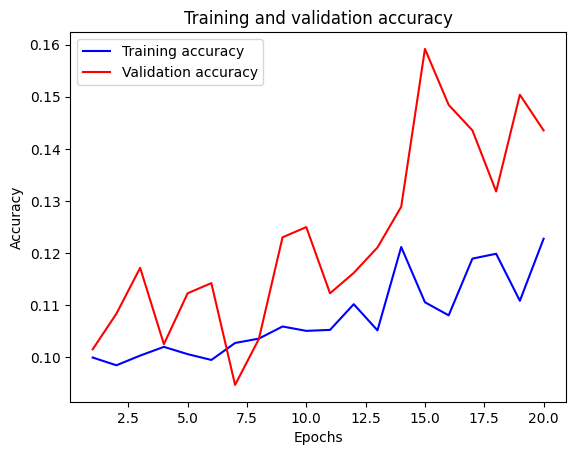

In [ ]:
epochs_range = range(1, N_EPOCHS+1)
plt.plot(epochs_range, train_acc_scores, color='blue', label='Training accuracy')
plt.plot(epochs_range, valid_acc_scores, color='red', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

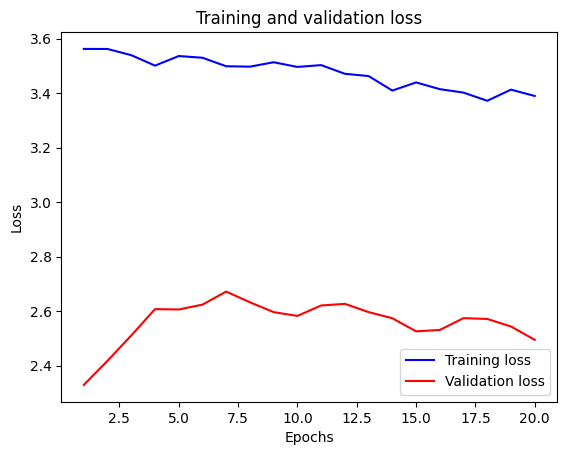

In [ ]:
epochs_range = range(1, N_EPOCHS+1)
plt.plot(epochs_range, train_loss_scores, color='blue', label='Training loss')
plt.plot(epochs_range, valid_loss_scores, color='red', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()